In [1]:
!pip install cvxpy
!pip install PyPortfolioOpt

In [2]:
import warnings
warnings.filterwarnings("ignore")

## For Collections, Manipulation and Visualization of Data
import cvxpy as cvx
import numpy as np
import pandas as pd
import pandas_datareader as web
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from copy import deepcopy
import statistics
import math

## For Optimisation
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions

In [3]:
def get_data_for_multiple_stocks(tickers, start_date, end_date):
    '''
    Obtain stocks information (Date, OHLC, Volume and Adjusted Close). 
    Uses Pandas DataReader to make an API Call to Yahoo Finance and download the data directly.
    Computes other values - Log Return and Arithmetic Return.
    
    Input: List of Stock Tickers
    Output: A dictionary of dataframes for each stock
    '''
    # read in stock data
    s = DataReader(tickers[0], 'yahoo', start_date, end_date)[["Adj Close"]]
    # get log returns
    s[tickers[0]] = np.log(s['Adj Close']/s['Adj Close'].shift(1))
    
    stocks = s[[tickers[0]]]
    
    for ticker in tickers[1:]:
        s = DataReader(ticker, 'yahoo', start_date, end_date)
        s[ticker] = np.log(s['Adj Close']/s['Adj Close'].shift(1))
        stocks[ticker] = s[ticker]
        
    # skip first row that will be na, and fillna by 0 incase there are trading halts on specific days
    return stocks.iloc[1:].fillna(0)

In [4]:
def get_adj_close_for_multiple_stocks(tickers, start_date, end_date):
    '''
    Obtain stocks information (Date, OHLC, Volume and Adjusted Close). 
    Uses Pandas DataReader to make an API Call to Yahoo Finance and download the data directly.
    Computes other values - Log Return and Arithmetic Return.
    
    Input: List of Stock Tickers
    Output: A dictionary of dataframes for each stock
    '''
    # read in stock data
    s = DataReader(tickers[0], 'yahoo', start_date, end_date)[["Adj Close"]]
    
    # get log returns
    s[tickers[0]] = s['Adj Close']
    
    stocks = s[[tickers[0]]]
    
    for ticker in tickers[1:]:
        s = DataReader(ticker, 'yahoo', start_date, end_date)
        #print(s)
        s[ticker] = s['Adj Close']
        stocks[ticker] = s[ticker]
        #print(stocks)
    # skip first row that will be na, and fillna by 0 incase there are trading halts on specific days
    #return stocks.iloc[1:].fillna(0)
    return stocks

In [5]:
tickers_best = ["FWRLX"]

In [6]:
FWRLX = web.get_data_yahoo("FWRLX",
                            start = "2020-01-01",
                            end = "2020-10-31")

In [7]:
FWRLX.head(n=5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-31,11.21,11.21,11.21,11.21,0.0,10.486161
2020-01-02,11.28,11.28,11.28,11.28,0.0,10.551641
2020-01-03,11.18,11.18,11.18,11.18,0.0,10.458098
2020-01-06,11.21,11.21,11.21,11.21,0.0,10.486161
2020-01-07,11.19,11.19,11.19,11.19,0.0,10.467452


In [8]:
FWRLX_monthly_returns = FWRLX['Adj Close'].resample('M').ffill().pct_change()

In [9]:
FWRLX_monthly_returns

Date
2019-12-31         NaN
2020-01-31    0.000892
2020-02-29   -0.046346
2020-03-31   -0.088785
2020-04-30    0.109596
2020-05-31    0.070158
2020-06-30    0.049861
2020-07-31    0.068602
2020-08-31    0.064198
2020-09-30   -0.046404
2020-10-31   -0.028386
Freq: M, Name: Adj Close, dtype: float64

In [10]:
def get_monthly_ann_sd(df):
    data = []
    daily_returns = []
    month = df['Date'][0].strftime("%m")
    
    for i, j in df.iterrows():
        if j.iloc[0].strftime("%m") == month:
            daily_returns.append(j.iloc[1])
        else:
            sd = statistics.stdev(daily_returns) * math.sqrt(252)
            daily_sd = [month, sd] #previous month
            data.append(daily_sd)
            
            month = j.iloc[0].strftime("%m") #reassign values for current month
            daily_returns = []
            daily_returns.append(j.iloc[1])
            
    sd = statistics.stdev(daily_returns) * math.sqrt(252) #last month
    daily_sd = [month, sd] 
    data.append(daily_sd)
    res = pd.DataFrame(data, columns = ['Month', 'Monthly_sd']) 

    return res

In [11]:
FWRLX_daily_returns = get_data_for_multiple_stocks(["FWRLX"],"2020-01-01","2020-10-31")
FWRLX_daily_returns = FWRLX_daily_returns.reset_index()
FWRLX_daily_returns['Date'] = pd.to_datetime(FWRLX_daily_returns['Date'], infer_datetime_format=True)
FWRLX_daily_returns.head()

,Date,FWRLX
0,2020-01-02,0.006225
1,2020-01-03,-0.008905
2,2020-01-06,0.002680
3,2020-01-07,-0.001786
4,2020-01-08,0.008011


In [12]:
FWRLX_sd = get_monthly_ann_sd(FWRLX_daily_returns)
FWRLX_sd

,Month,Monthly_sd
0,01,0.133570
1,02,0.234745
2,03,0.831624
3,04,0.372993
4,05,0.200236
5,06,0.267024
6,07,0.161638
7,08,0.109724
8,09,0.258350
9,10,0.202412


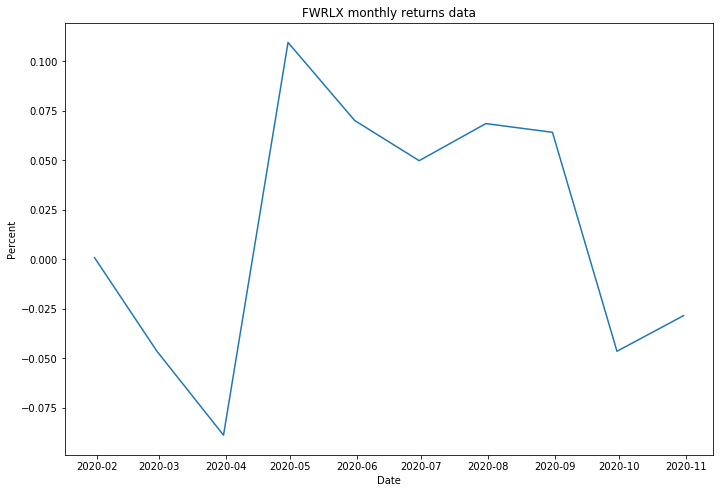

In [13]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,1.5,1.5])
ax1.plot(FWRLX_monthly_returns)
#Date = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("FWRLX monthly returns data")
plt.show()

In [14]:
RYTLX = web.get_data_yahoo("RYTLX",
                            start = "2020-01-01",
                            end = "2020-10-31")

In [15]:
RYTLX.head(n=5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-31,45.099998,45.099998,45.099998,45.099998,0,45.099998
2020-01-02,45.220001,45.220001,45.220001,45.220001,0,45.220001
2020-01-03,44.939999,44.939999,44.939999,44.939999,0,44.939999
2020-01-06,45.060001,45.060001,45.060001,45.060001,0,45.060001
2020-01-07,44.930000,44.930000,44.930000,44.930000,0,44.930000


In [16]:
RYTLX_monthly_returns = RYTLX['Adj Close'].resample('M').ffill().pct_change()

In [17]:
RYTLX_monthly_returns

Date
2019-12-31         NaN
2020-01-31   -0.017738
2020-02-29   -0.028668
2020-03-31   -0.084360
2020-04-30    0.087056
2020-05-31    0.045762
2020-06-30   -0.013842
2020-07-31    0.047091
2020-08-31   -0.004541
2020-09-30   -0.061903
2020-10-31   -0.023154
Freq: M, Name: Adj Close, dtype: float64

In [18]:
RYTLX_daily_returns = get_data_for_multiple_stocks(["RYTLX"],"2020-01-01","2020-10-31")
RYTLX_daily_returns = RYTLX_daily_returns.reset_index()
RYTLX_daily_returns['Date'] = pd.to_datetime(RYTLX_daily_returns['Date'], infer_datetime_format=True)
RYTLX_daily_returns.head()

,Date,RYTLX
0,2020-01-02,0.002657
1,2020-01-03,-0.006211
2,2020-01-06,0.002667
3,2020-01-07,-0.002889
4,2020-01-08,0.003555


In [19]:
RYTLX_sd = get_monthly_ann_sd(RYTLX_daily_returns)
RYTLX_sd

,Month,Monthly_sd
0,01,0.120686
1,02,0.246061
2,03,0.817189
3,04,0.370931
4,05,0.276900
5,06,0.290482
6,07,0.128660
7,08,0.088089
8,09,0.207025
9,10,0.162322


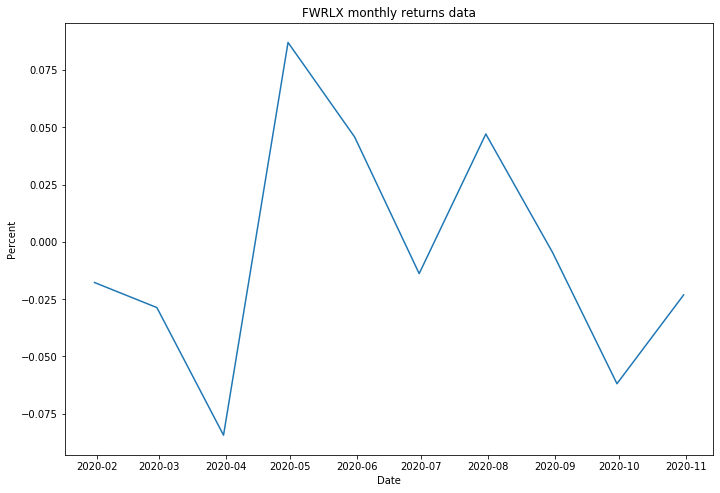

In [20]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,1.5,1.5])
ax1.plot(RYTLX_monthly_returns)
#Date = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("FWRLX monthly returns data")
plt.show()

In [21]:
tickers = ["AAPL", "VZ","AMT", "T", "GOOG",
           "MRVL", "ATVI", "QCOM", "TMUS",
           "ERCA.BE", "VOD", "RNG", "ORA", "MAS",
           "CHL","QRVO", "BCE", "TEF",
           "SWKS", "LBTYA", "MU", "NXPI",
           "LPSN", "CHA", "IRDM", "MSI",
           "ILD.PA", "DISH", "NOK", "USM"]

returns_df = get_data_for_multiple_stocks(tickers, start_date = "2017-01-01", end_date = "2019-12-31")

In [22]:
in_sample = "2018-12-31"
is_returns_df = returns_df.loc[:in_sample]
oos_returns_df = returns_df.loc[in_sample:].iloc[1:] # one day after in_sample date

In [23]:
# Calculate Lambda to use with quadratic Utility Function
starting_capital = 150000
VaR_limit = starting_capital/(3*math.sqrt(10))
value_invested = starting_capital - VaR_limit
print("Amount set aside to cover VaR: $" + str(VaR_limit))
print("Amount invested: $" + str(value_invested))

w1 = value_invested/1000000
lambda1 = (((2*w1)/(1-2*w1)**2))/4
print("Lambda used for risk aversion = " + str(lambda1))

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(is_returns_df, returns_data=True)
S = risk_models.sample_cov(is_returns_df, returns_data=True)

Amount set aside to cover VaR: $15811.388300841896
Amount invested: $134188.6116991581
Lambda used for risk aversion = 0.1253462164718553


In [24]:
## no stocks will hold more than 20%
ef_max_utility = EfficientFrontier(mu, S, weight_bounds=(0, 0.2))

## objective function
ef_max_utility.add_objective(objective_functions.L2_reg, gamma=1)

weights_max_utility = ef_max_utility.max_quadratic_utility(risk_aversion = lambda1)
ef_max_utility.portfolio_performance(verbose=True) # return, vol, sharpe

Expected annual return: 34.8%
Annual volatility: 20.7%
Sharpe Ratio: 1.58


(0.34842350152889195, 0.20723143705230043, 1.5848150560573753)

In [25]:
weights_max_utility

OrderedDict([('AAPL', 0.0669385591243549),
             ('VZ', 0.015626530988775),
             ('AMT', 0.1062763879382531),
             ('T', 0.0),
             ('GOOG', 0.0507886973113026),
             ('MRVL', 0.0087570787417187),
             ('ATVI', 0.0258625660824788),
             ('QCOM', 0.0),
             ('TMUS', 0.0),
             ('ERCA.BE', 0.0594409907467118),
             ('VOD', 0.0),
             ('RNG', 0.2),
             ('ORA', 0.0),
             ('MAS', 0.0),
             ('CHL', 0.0),
             ('QRVO', 0.0),
             ('BCE', 0.0),
             ('TEF', 0.0),
             ('SWKS', 0.0),
             ('LBTYA', 0.0),
             ('MU', 0.0310135281665467),
             ('NXPI', 0.0),
             ('LPSN', 0.2),
             ('CHA', 0.0179241081447344),
             ('IRDM', 0.1016130209592798),
             ('MSI', 0.0796650028964607),
             ('ILD.PA', 0.0),
             ('DISH', 0.0),
             ('NOK', 0.0360935288993834),
             ('USM', 

In [26]:
optim_portfolio = get_data_for_multiple_stocks(tickers, start_date = "2020-01-01", end_date = "2020-10-31")
optim_portfolio = (optim_portfolio * weights_max_utility).sum(axis=1) 

In [27]:
max_utility = optim_portfolio.to_frame()
max_utility = max_utility.rename(columns={0: 'log_returns'})
max_utility = max_utility.reset_index()
max_utility = max_utility.reset_index()
max_utility = max_utility[['Date','log_returns']]
max_utility.head()

,Date,log_returns
0,2020-01-02,0.012753
1,2020-01-03,-0.004818
2,2020-01-06,0.008865
3,2020-01-07,-0.003198
4,2020-01-08,0.017533


In [28]:
RYTLX_monthly_returns = RYTLX_monthly_returns.reset_index()

In [29]:
dates = RYTLX_monthly_returns.loc[1:10, 'Date'].dt.date
dates

1     2020-01-31
2     2020-02-29
3     2020-03-31
4     2020-04-30
5     2020-05-31
6     2020-06-30
7     2020-07-31
8     2020-08-31
9     2020-09-30
10    2020-10-31
Name: Date, dtype: object

In [30]:
def get_monthly_return(df):
    
    data = []
    month = df['Date'][0].strftime("%m")
    monthly_return = 1
    
    for i, j in df.iterrows():
        if j.iloc[0].strftime("%m") == month:
            x = j.iloc[1] + 1
            monthly_return = monthly_return * x
        else:
            returns = [month, monthly_return - 1] #previous month
            data.append(returns)
            month = j.iloc[0].strftime("%m") #reassign values for current month
            monthly_return = 1
            
            x = j.iloc[1] + 1 #calculate first value of the month
            monthly_return = monthly_return * x
            
    returns = [month, monthly_return - 1] #last month
    data.append(returns)
    res = pd.DataFrame(data, columns = ['Month', 'Monthly_returns']) 

    return res

In [31]:
optimal_monthly_returns = get_monthly_return(max_utility)
optimal_monthly_returns

,Month,Monthly_returns
0,01,0.073930
1,02,-0.078022
2,03,-0.147185
3,04,0.075415
4,05,0.156373
5,06,0.052601
6,07,0.045531
7,08,0.093676
8,09,-0.076313
9,10,-0.012061


In [32]:
optimal_sd = get_monthly_ann_sd(max_utility)
optimal_sd

,Month,Monthly_sd
0,01,0.167368
1,02,0.349899
2,03,0.904812
3,04,0.472809
4,05,0.320237
5,06,0.339800
6,07,0.256360
7,08,0.203507
8,09,0.322176
9,10,0.238770


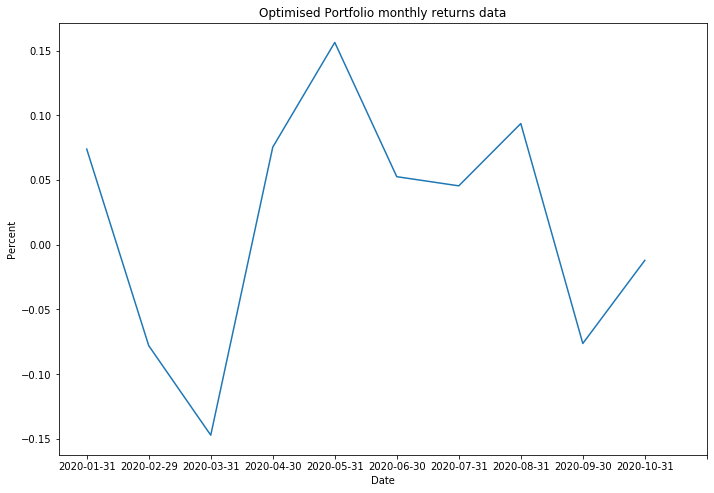

In [33]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,1.5,1.5])
ax1.plot(optimal_monthly_returns['Monthly_returns'])

plt.xticks(list(range(0,11)), dates)
#Date = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("Optimised Portfolio monthly returns data")
plt.show()

Optimised Portfolio (After Adjustment)

In [34]:
tickers = ["AAPL", "VZ","AMT", "T", "GOOG",
           "MRVL", "ATVI", "QCOM", "TMUS",
           "ERCA.BE", "VOD", "RNG", "ORA", "MAS",
           "CHL","QRVO", "BCE", "TEF",
           "SWKS", "LBTYA", "MU", "NXPI",
           "LPSN", "CHA", "IRDM", "MSI",
           "ILD.PA", "DISH", "NOK", "USM"]

returns_df = get_data_for_multiple_stocks(tickers, start_date = "2019-09-30", end_date = "2020-09-30")

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(returns_df, returns_data=True)
S = risk_models.sample_cov(returns_df, returns_data=True)

In [35]:
## no stocks will hold more than 30%
## Lifted from midterms code
lambda1  = 0.256487
ef_max_utility_Sept2020 = EfficientFrontier(mu, S, weight_bounds=(0, 0.3))

## Constraint on individual stocks
ef_max_utility_Sept2020.add_constraint(lambda x : x[0] >= 0.07) # Apple >= 7%
ef_max_utility_Sept2020.add_constraint(lambda x : x[1] >= 0.07) # Verizon >= 7%
ef_max_utility_Sept2020.add_constraint(lambda x : x[2] >= 0.05)# American Tower Corp >= 5%
ef_max_utility_Sept2020.add_constraint(lambda x : x[3] >= 0.05)# AT&T >= 5%
ef_max_utility_Sept2020.add_constraint(lambda x : x[7] >= 0.05)# Qualcomm >= 5%
ef_max_utility_Sept2020.add_constraint(lambda x : x[8] >= 0.05)# T-Mobile Corp >= 5%
ef_max_utility_Sept2020.add_constraint(lambda x : x[18] >= 0.05)# SkyWork Solutions >= 5%

ef_max_utility_Sept2020.add_constraint(lambda x : x[4] <= 0.5) #Google <= 5%
## objective function
ef_max_utility_Sept2020.add_objective(objective_functions.L2_reg, gamma=1)

weights_max_utility_Sept2020 = ef_max_utility_Sept2020.max_quadratic_utility(risk_aversion = lambda1)
ef_max_utility_Sept2020.portfolio_performance(verbose=True) # return, vol, sharpe

Expected annual return: 56.5%
Annual volatility: 34.7%
Sharpe Ratio: 1.57


(0.5653140939151527, 0.34737887997585176, 1.5697963386635956)

In [36]:
weights_max_utility_Sept2020

OrderedDict([('AAPL', 0.253430429555267),
             ('VZ', 0.07),
             ('AMT', 0.05),
             ('T', 0.05),
             ('GOOG', 0.0),
             ('MRVL', 0.0),
             ('ATVI', 0.0233471890153408),
             ('QCOM', 0.05),
             ('TMUS', 0.05),
             ('ERCA.BE', 0.0),
             ('VOD', 0.0),
             ('RNG', 0.1662742428434342),
             ('ORA', 0.0),
             ('MAS', 0.0),
             ('CHL', 0.0),
             ('QRVO', 0.0359242662917381),
             ('BCE', 0.0),
             ('TEF', 0.0),
             ('SWKS', 0.0977874896252798),
             ('LBTYA', 0.0),
             ('MU', 0.0),
             ('NXPI', 0.0),
             ('LPSN', 0.0),
             ('CHA', 0.0),
             ('IRDM', 0.0),
             ('MSI', 0.0),
             ('ILD.PA', 0.1532363826689402),
             ('DISH', 0.0),
             ('NOK', 0.0),
             ('USM', 0.0)])

In [37]:
optim_portfolio_adjusted = get_data_for_multiple_stocks(tickers, start_date = "2020-01-01", end_date = "2020-10-31")
optim_portfolio_adjusted = (optim_portfolio_adjusted * weights_max_utility_Sept2020).sum(axis=1) 

In [38]:
max_utility_adjusted = optim_portfolio_adjusted.to_frame()
max_utility_adjusted = max_utility_adjusted.rename(columns={0: 'log_returns'})
max_utility_adjusted = max_utility_adjusted.reset_index()
max_utility_adjusted = max_utility_adjusted.reset_index()
max_utility_adjusted = max_utility_adjusted[['Date','log_returns']]
max_utility_adjusted.head()

,Date,log_returns
0,2020-01-02,0.011279
1,2020-01-03,-0.009896
2,2020-01-06,0.006292
3,2020-01-07,-0.000019
4,2020-01-08,0.011353


In [39]:
optimal_adjusted_monthly_returns = get_monthly_return(max_utility_adjusted)
optimal_adjusted_monthly_returns

,Month,Monthly_returns
0,01,0.038611
1,02,-0.023627
2,03,-0.110245
3,04,0.110257
4,05,0.107987
5,06,0.072993
6,07,0.069592
7,08,0.073161
8,09,-0.065105
9,10,-0.030474


In [40]:
optimal_adjusted_sd = get_monthly_ann_sd(max_utility_adjusted)
optimal_adjusted_sd

,Month,Monthly_sd
0,01,0.173259
1,02,0.260225
2,03,0.920150
3,04,0.369347
4,05,0.206121
5,06,0.244940
6,07,0.210688
7,08,0.147257
8,09,0.330880
9,10,0.234728


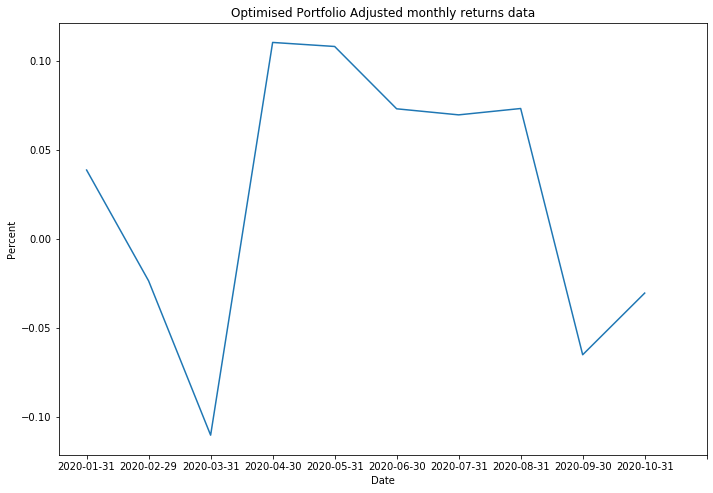

In [41]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,1.5,1.5])
ax1.plot(optimal_adjusted_monthly_returns['Monthly_returns'])

plt.xticks(list(range(0,11)), dates)
#Date = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("Optimised Portfolio Adjusted monthly returns data")
plt.show()

# Point 3: Adjustment of Mutual Fund holdings and Fund Managers' decisions

FWRLX

In [42]:
from collections import OrderedDict

In [43]:
# Top 30 Stocks with retrievable data from Yahoo
best_tickers = ["AAPL", "ORA", "AMT", "VZ", "T", 
                "ATVI", "TMUS", "AMZN", "RNG", "MSI", 
                "LYFT", "ERIC", "MRVL", "COMM", "VOD", 
                "CHL", "CCI", "QCOM", "SSNLF", "BEZQ.TA",
                "SWKS", "BCE", "LBTYK", "ERIC-B.ST", "IDL.PA", 
                "TEF", "NXPI", "VSAT", "LPSN", "DISH"]

In [44]:
# Weights have been pre-calculated via the portfolio holdings values found online
weights_feb = OrderedDict([("AAPL", 0.130499013779), 
               ("ORA", 0.083949722377),
               ("AMT", 0.082662504900),
               ("VZ", 0.081208072629),
               ("T", 0.044857902777),
                ("ATVI", 0.041438847257),
               ("TMUS", 0.035639614545),
               ("AMZN", 0.034042852562),
               ("RNG", 0.031461705443),
               ("MSI", 0.027116815674), 
                ("LYFT", 0.026312295048),
               ("ERIC", 0.026312295048),
               ("MRVL", 0.025914703167),
               ("COMM", 0.023956120253),
               ("VOD", 0.021611621266), 
                ("CHL", 0.021433639929),
               ("CCI", 0.019601040878),
               ("QCOM", 0.019385857131),
               ("SSNLF", 0.019141676458),
               ("BEZQ.TA", 0.017975817004),
               ("SWKS", 0.017547324146),
                ("BCE", 0.017217053586),
                ("LBTYK", 0.017014009871),
                ("ERIC-B.ST", 0.003503317925),
                ("IDL.PA", 0.014497044103),
                ("TEF", 0.012451729698),
               ("NXPI", 0.010297265600),
               ("VSAT", 0.011126860572),
               ("LPSN", 0.006326705412),
               ("DISH", 0.004552490094)])

In [45]:
total = 0
number_stocks = len(weights_feb)
for i in range(0,number_stocks):
    total = total+ list(weights_feb.items())[i][1]
print("Total weight adds up to {total}".format (total = total))

Total weight adds up to 0.9290559191320001


In [46]:
returns_df = get_data_for_multiple_stocks(best_tickers, start_date = "2020-06-01", end_date = "2020-10-31")
returns_df.head()

,AAPL,ORA,AMT,VZ,T,ATVI,TMUS,AMZN,RNG,MSI,...,SWKS,BCE,LBTYK,ERIC-B.ST,IDL.PA,TEF,NXPI,VSAT,LPSN,DISH
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-02,0.004619,-0.027646,-0.002728,0.011054,0.001938,-0.000137,0.007096,0.000554,-0.019519,0.005169,...,0.038462,0.013223,-0.002319,0.011271,-0.021979,0.016033,0.022529,0.008034,-0.017984,-0.005532
2020-06-03,0.005490,0.024392,0.014313,0.007595,0.016640,-0.042834,0.007936,0.002420,-0.011122,0.057123,...,0.027807,0.016748,0.000928,0.039027,-0.011173,0.046610,0.067645,0.034823,-0.016635,0.044599
2020-06-04,-0.008649,-0.017444,-0.029104,0.006839,0.009161,-0.001574,-0.010329,-0.007208,-0.064290,0.009155,...,0.011019,0.005521,0.022019,-0.020894,-0.028492,-0.001899,0.009170,-0.008203,-0.056649,0.023592
2020-06-05,0.028083,0.028720,0.019711,0.009047,0.030047,-0.005458,0.009538,0.009062,-0.004655,0.043726,...,0.056580,0.015931,0.029065,-0.007214,-0.010459,0.035485,0.038237,0.010409,0.034316,0.030615
2020-06-08,0.005895,0.014056,0.007484,0.006043,0.013939,0.018551,0.032397,0.016401,0.032333,0.015404,...,-0.010484,0.010333,0.028673,-0.020341,-0.036887,0.037808,0.002457,0.043752,-0.029888,0.041023


In [47]:
portfolio_feb = (returns_df * weights_feb).sum(axis = 1)

In [48]:
portfolio_feb = portfolio_feb.to_frame()
portfolio_feb = portfolio_feb.rename(columns={0: 'log_returns'})
portfolio_feb = portfolio_feb.reset_index()
portfolio_feb = portfolio_feb.reset_index()
portfolio_feb = portfolio_feb[['Date','log_returns']]
portfolio_feb.head()

,Date,log_returns
0,2020-06-02,0.003381
1,2020-06-03,0.012483
2,2020-06-04,-0.007112
3,2020-06-05,0.018657
4,2020-06-08,0.010998


In [49]:
RYTLX_monthly_returns = RYTLX_monthly_returns.reset_index()

In [50]:
dates = RYTLX_monthly_returns.loc[1:10, 'Date'].dt.date
dates

1     2020-01-31
2     2020-02-29
3     2020-03-31
4     2020-04-30
5     2020-05-31
6     2020-06-30
7     2020-07-31
8     2020-08-31
9     2020-09-30
10    2020-10-31
Name: Date, dtype: object

In [51]:
optimal_monthly_returns_feb = get_monthly_return(portfolio_feb)
optimal_monthly_returns_feb

,Month,Monthly_returns
0,06,0.006891
1,07,0.041791
2,08,0.048936
3,09,-0.044761
4,10,-0.018459


In [52]:
optimal_sd_feb = get_monthly_ann_sd(portfolio_feb)
optimal_sd_feb

,Month,Monthly_sd
0,06,0.246628
1,07,0.141783
2,08,0.098299
3,09,0.208373
4,10,0.180312


In [53]:
# Weights have been pre-calculated via the portfolio holdings values found online
weights_may = OrderedDict([("AAPL", 0.1420392632), 
               ("ORA", 0.03489671694),
               ("AMT", 0.0867451305),
               ("VZ", 0.07182211856),
               ("T", 0.02782935626),
                ("ATVI", 0.02910015296),
               ("TMUS", 0.05639936857),
               ("AMZN", 0.01490932615),
               ("RNG", 0.0337872997),
               ("MSI", 0.02709958432), 
                ("LYFT", 0.02058309079),
               ("ERIC", 0),
               ("MRVL", 0.03796087904),
               ("COMM", 0.01325965674),
               ("VOD", 0.01885040726), 
                ("CHL", 0.01745352228),
               ("CCI", 0.01022327866),
               ("QCOM", 0.0187279983),
               ("SSNLF", 0.01635888985),
               ("BEZQ.TA", 0.01932283036),
               ("SWKS", 0.01993248403),
                ("BCE", 0.01535108407),
                ("LBTYK", 0.0174744328),
                ("ERIC-B.ST", 0.0277756038),
                ("IDL.PA", 0.01795189934),
                ("TEF", 0.009711663464),
               ("NXPI", 0.008639572941),
               ("VSAT", 0),
               ("LPSN", 0.01341534797),
               ("DISH", 0.01135075589)])

In [54]:
total = 0
number_stocks = len(weights_may)
for i in range(0,number_stocks):
    total = total+ list(weights_may.items())[i][1]
print("Total weight adds up to {total}".format (total = total))

Total weight adds up to 0.838971714745


In [55]:
returns_df = get_data_for_multiple_stocks(best_tickers, start_date = "2020-06-01", end_date = "2020-10-31")
returns_df.head()

,AAPL,ORA,AMT,VZ,T,ATVI,TMUS,AMZN,RNG,MSI,...,SWKS,BCE,LBTYK,ERIC-B.ST,IDL.PA,TEF,NXPI,VSAT,LPSN,DISH
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-02,0.004619,-0.027646,-0.002728,0.011054,0.001938,-0.000137,0.007096,0.000554,-0.019519,0.005169,...,0.038462,0.013223,-0.002319,0.011271,-0.021979,0.016033,0.022529,0.008034,-0.017984,-0.005532
2020-06-03,0.005490,0.024392,0.014313,0.007595,0.016640,-0.042834,0.007936,0.002420,-0.011122,0.057123,...,0.027807,0.016748,0.000928,0.039027,-0.011173,0.046610,0.067645,0.034823,-0.016635,0.044599
2020-06-04,-0.008649,-0.017444,-0.029104,0.006839,0.009161,-0.001574,-0.010329,-0.007208,-0.064290,0.009155,...,0.011019,0.005521,0.022019,-0.020894,-0.028492,-0.001899,0.009170,-0.008203,-0.056649,0.023592
2020-06-05,0.028083,0.028720,0.019711,0.009047,0.030047,-0.005458,0.009538,0.009062,-0.004655,0.043726,...,0.056580,0.015931,0.029065,-0.007214,-0.010459,0.035485,0.038237,0.010409,0.034316,0.030615
2020-06-08,0.005895,0.014056,0.007484,0.006043,0.013939,0.018551,0.032397,0.016401,0.032333,0.015404,...,-0.010484,0.010333,0.028673,-0.020341,-0.036887,0.037808,0.002457,0.043752,-0.029888,0.041023


In [56]:
portfolio_may = (returns_df * weights_may).sum(axis = 1)

In [57]:
portfolio_may = portfolio_may.to_frame()
portfolio_may = portfolio_may.rename(columns={0: 'log_returns'})
portfolio_may = portfolio_may.reset_index()
portfolio_may = portfolio_may.reset_index()
portfolio_may = portfolio_may[['Date','log_returns']]
portfolio_may.head()

,Date,log_returns
0,2020-06-02,0.004556
1,2020-06-03,0.011127
2,2020-06-04,-0.006759
3,2020-06-05,0.016091
4,2020-06-08,0.008117


In [58]:
RYTLX_monthly_returns = RYTLX_monthly_returns.reset_index()

In [59]:
dates = RYTLX_monthly_returns.loc[1:10, 'Date'].dt.date
dates

1     2020-01-31
2     2020-02-29
3     2020-03-31
4     2020-04-30
5     2020-05-31
6     2020-06-30
7     2020-07-31
8     2020-08-31
9     2020-09-30
10    2020-10-31
Name: Date, dtype: object

In [60]:
optimal_monthly_returns_may = get_monthly_return(portfolio_may)
optimal_monthly_returns_may

,Month,Monthly_returns
0,06,0.018632
1,07,0.042474
2,08,0.051370
3,09,-0.039277
4,10,-0.026148


In [61]:
optimal_sd_may = get_monthly_ann_sd(portfolio_may)
optimal_sd_may

,Month,Monthly_sd
0,06,0.213450
1,07,0.133303
2,08,0.086694
3,09,0.204346
4,10,0.165738


In [62]:
monthly_result = pd.concat([optimal_monthly_returns_feb,optimal_monthly_returns_may['Monthly_returns']],axis=1)
monthly_result.columns = ["Month","Portfolio with Feb Weights", "Portfolio with May Weights"]
#monthly_result = monthly_result.reset_index()
monthly_result

,Month,Portfolio with Feb Weights,Portfolio with May Weights
0,06,0.006891,0.018632
1,07,0.041791,0.042474
2,08,0.048936,0.051370
3,09,-0.044761,-0.039277
4,10,-0.018459,-0.026148


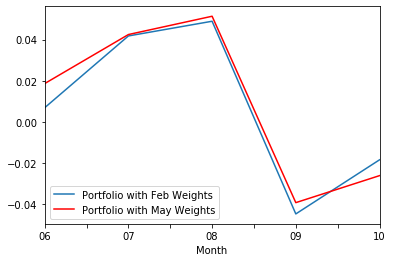

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

ax = plt.gca()

monthly_result.plot(kind='line',x='Month',y='Portfolio with Feb Weights',ax=ax)
monthly_result.plot(kind='line',x='Month',y='Portfolio with May Weights', color='red', ax=ax)

plt.show()

In [64]:
monthly_result = pd.concat([optimal_sd_feb,optimal_sd_may['Monthly_sd']],axis=1)
monthly_result.columns = ["Month","Portfolio with Feb Weights", "Portfolio with May Weights"]
#monthly_result = monthly_result.reset_index()
monthly_result

,Month,Portfolio with Feb Weights,Portfolio with May Weights
0,06,0.246628,0.213450
1,07,0.141783,0.133303
2,08,0.098299,0.086694
3,09,0.208373,0.204346
4,10,0.180312,0.165738


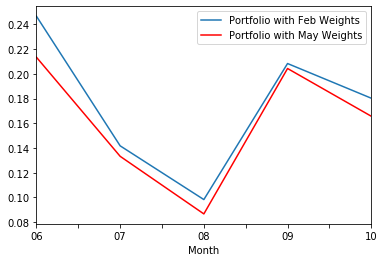

In [65]:
ax = plt.gca()

monthly_result.plot(kind='line',x='Month',y='Portfolio with Feb Weights',ax=ax)
monthly_result.plot(kind='line',x='Month',y='Portfolio with May Weights', color='red', ax=ax)

plt.show()

RYTLX

In [66]:
# Weights have been pre-calculated via the portfolio holdings values found online
weights_march = OrderedDict([
                ("VZ", 0.14009701008837),
                ("AT", 0.11679672753950),
                ("CSCO", 0.115525339817475),
                ("TMUS", 0.052288799241277),
                 ("MSI", 0.038452287484296),
                 ("LUMN", 0.026941585199414),
                ("UI", 0.025986332239555),
                 ("CIEN", 0.024069251593412),
                  ("LITE", 0.022733760288762),
                   ("JNPR", 0.022289418361348),
                 ("GLIBA", 0.022099299188953),
                  ("CCOI", 0.021916576583783),
                  ("FFIV", 0.021674407493873),
                   ("SHEN",0.017485484921687),
                    ("ACIA", 0.016563379540876),
                 ("IRDM", 0.016204509056960),
                ("CHL", 0.015479371521901),
                ("VIV", 0.0104976465218875),
                 ("BCE", 0.014573976904082),
                 ("SATS", 0.015212821154840),
                 ("VOD", 0.013395183245844),
                  ("AMX", 0.013017958317330),
                ("NTCT", 0.012968647869159),
                 ("BAND", 0.012922076890330),
                 ("VG", 0.012880163009384), 
                 ("VSAT", 0.0104403916126215),
                  ("TU", 0.012294190516943),
                  ("TDS", 0.011280860807015),
                  ("COMM", 0.010668863355817),
                  ("IDCC", 0.010575721398159)])

In [67]:
total = 0
number_stocks = len(weights_march)
for i in range(0,number_stocks):
    total = total+ list(weights_march.items())[i][1]
print("Total weight adds up to {total}".format (total = total))

Total weight adds up to 0.8773320417648537


In [68]:
returns_df = get_data_for_multiple_stocks(best_tickers, start_date = "2020-07-01", end_date = "2020-10-31")
returns_df.head()

,AAPL,ORA,AMT,VZ,T,ATVI,TMUS,AMZN,RNG,MSI,...,SWKS,BCE,LBTYK,ERIC-B.ST,IDL.PA,TEF,NXPI,VSAT,LPSN,DISH
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,-0.001893,-0.001419,0.026150,-0.008379,-0.010976,0.027677,0.018833,0.042536,0.018425,-0.030136,...,-0.015845,-0.009864,-0.002327,-0.001859,-0.014019,-0.004158,-0.018854,-0.042594,0.036264,0.003471
2020-07-02,0.000000,0.002363,-0.004456,0.002193,0.006002,-0.006686,-0.001131,0.004022,-0.009274,-0.006493,...,0.020215,0.005545,0.024852,0.014086,0.052704,-0.004175,0.007212,-0.002451,0.022100,-0.046396
2020-07-06,0.026399,-0.021150,0.006639,0.008180,0.013538,0.014855,0.007237,0.056087,0.010926,0.006787,...,0.023320,-0.004337,0.035279,0.052738,-0.005450,-0.002094,0.033242,0.021042,-0.005251,0.013221
2020-07-07,-0.003108,-0.020787,0.000000,-0.003627,-0.005591,-0.002163,-0.009220,-0.018795,-0.014060,-0.036921,...,0.006294,-0.013860,-0.011030,-0.037029,-0.003284,-0.034118,-0.009484,-0.025961,-0.008967,-0.024782
2020-07-08,0.023023,0.023996,-0.004786,0.006158,0.004607,0.009887,0.007627,0.026638,0.026127,0.007979,...,-0.000983,0.001223,0.002216,-0.010673,-0.005498,0.000000,0.008626,0.028894,0.022380,-0.021965


In [69]:
portfolio_march = (returns_df * weights_march).sum(axis = 1)

In [70]:
portfolio_march = portfolio_march.to_frame()
portfolio_march = portfolio_march.rename(columns={0: 'log_returns'})
portfolio_march = portfolio_march.reset_index()
portfolio_march = portfolio_march.reset_index()
portfolio_march = portfolio_march[['Date','log_returns']]
portfolio_march.head()

,Date,log_returns
0,2020-07-01,-0.002061
1,2020-07-02,0.000954
2,2020-07-06,0.003575
3,2020-07-07,-0.004726
4,2020-07-08,0.001809


In [71]:
dates = RYTLX_monthly_returns.loc[1:10, 'Date'].dt.date
dates

1     2020-01-31
2     2020-02-29
3     2020-03-31
4     2020-04-30
5     2020-05-31
6     2020-06-30
7     2020-07-31
8     2020-08-31
9     2020-09-30
10    2020-10-31
Name: Date, dtype: object

In [72]:
optimal_monthly_returns_march = get_monthly_return(portfolio_march)
optimal_monthly_returns_march

,Month,Monthly_returns
0,07,0.009561
1,08,0.015042
2,09,-0.005818
3,10,-0.007846


In [73]:
optimal_sd_march = get_monthly_ann_sd(portfolio_march)
optimal_sd_march

,Month,Monthly_sd
0,07,0.035591
1,08,0.030959
2,09,0.048702
3,10,0.044183


In [74]:
# Weights have been pre-calculated via the portfolio holdings values found online
weights_june = OrderedDict([
                ("VZ", 0.116853986895027),
                ("AT", 0.115194057738517),
                ("CSCO", 0.111907170730700),
                ("TMUS", 0.086832493125243),
                 ("MSI", 0.042681354582859),
                 ("LUMN", 0.029193209767765),
                ("UI", 0.029475866685169),
                 ("CIEN", 0.025702252788436),
                  ("LITE", 0.023121047744851),
                   ("JNPR", 0.023896033471957),
                 ("GLIBA", 0.024428055891804),
                  ("CCOI", 0.016727815633424),
                  ("FFIV", 0.025941054668825),
                   ("SHEN", 0.013514073705592),
                    ("ACIA", 0.014657825875336),
                 ("IRDM", 0.015737556093233),
                ("CHL", 0.013789047988774),
                ("VIV", 0.0116212646992401),
                 ("BCE", 0.013350977783262),
                 ("SATS", 0.014069784247623),
                 ("VOD", 0.013986075545583),
                  ("AMX", 0.014258328895812),
                ("NTCT", 0.012264845370181),
                 ("BAND", 0.015062284556129),
                 ("VG", 0.014108197418731), 
                 ("VSAT", 0.0132222936600502),
                  ("TU", 0.011874471518794),
                  ("TDS", 0.013252544032298),
                  ("COMM", 0.010491437304023),
                  ("IDCC", 0.011900880573931)])

In [75]:
total = 0
number_stocks = len(weights_june)
for i in range(0,number_stocks):
    total = total+ list(weights_june.items())[i][1]
print("Total weight adds up to {total}".format (total = total))

Total weight adds up to 0.8991162889931693


In [76]:
returns_df = get_data_for_multiple_stocks(best_tickers, start_date = "2020-07-01", end_date = "2020-10-31")
returns_df.head()

,AAPL,ORA,AMT,VZ,T,ATVI,TMUS,AMZN,RNG,MSI,...,SWKS,BCE,LBTYK,ERIC-B.ST,IDL.PA,TEF,NXPI,VSAT,LPSN,DISH
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,-0.001893,-0.001419,0.026150,-0.008379,-0.010976,0.027677,0.018833,0.042536,0.018425,-0.030136,...,-0.015845,-0.009864,-0.002327,-0.001859,-0.014019,-0.004158,-0.018854,-0.042594,0.036264,0.003471
2020-07-02,0.000000,0.002363,-0.004456,0.002193,0.006002,-0.006686,-0.001131,0.004022,-0.009274,-0.006493,...,0.020215,0.005545,0.024852,0.014086,0.052704,-0.004175,0.007212,-0.002451,0.022100,-0.046396
2020-07-06,0.026399,-0.021150,0.006639,0.008180,0.013538,0.014855,0.007237,0.056087,0.010926,0.006787,...,0.023320,-0.004337,0.035279,0.052738,-0.005450,-0.002094,0.033242,0.021042,-0.005251,0.013221
2020-07-07,-0.003108,-0.020787,0.000000,-0.003627,-0.005591,-0.002163,-0.009220,-0.018795,-0.014060,-0.036921,...,0.006294,-0.013860,-0.011030,-0.037029,-0.003284,-0.034118,-0.009484,-0.025961,-0.008967,-0.024782
2020-07-08,0.023023,0.023996,-0.004786,0.006158,0.004607,0.009887,0.007627,0.026638,0.026127,0.007979,...,-0.000983,0.001223,0.002216,-0.010673,-0.005498,0.000000,0.008626,0.028894,0.022380,-0.021965


In [77]:
portfolio_june = (returns_df * weights_june).sum(axis = 1)

In [78]:
portfolio_june = portfolio_june.to_frame()
portfolio_june = portfolio_june.rename(columns={0: 'log_returns'})
portfolio_june = portfolio_june.reset_index()
portfolio_june = portfolio_june.reset_index()
portfolio_june = portfolio_june[['Date','log_returns']]
portfolio_june.head()

,Date,log_returns
0,2020-07-01,-0.001447
1,2020-07-02,0.000761
2,2020-07-06,0.003608
3,2020-07-07,-0.005108
4,2020-07-08,0.002034


In [79]:
dates = RYTLX_monthly_returns.loc[1:10, 'Date'].dt.date
dates

1     2020-01-31
2     2020-02-29
3     2020-03-31
4     2020-04-30
5     2020-05-31
6     2020-06-30
7     2020-07-31
8     2020-08-31
9     2020-09-30
10    2020-10-31
Name: Date, dtype: object

In [80]:
optimal_monthly_returns_june = get_monthly_return(portfolio_june)
optimal_monthly_returns_june

,Month,Monthly_returns
0,07,0.009267
1,08,0.017621
2,09,-0.006811
3,10,-0.008475


In [81]:
optimal_sd_june = get_monthly_ann_sd(portfolio_june)
optimal_sd_june

,Month,Monthly_sd
0,07,0.036668
1,08,0.037428
2,09,0.055435
3,10,0.049807


In [82]:
monthly_result = pd.concat([optimal_monthly_returns_march,optimal_monthly_returns_june['Monthly_returns']],axis=1)
monthly_result.columns = ["Month","Portfolio with March Weights", "Portfolio with June Weights"]
#monthly_result = monthly_result.reset_index()
monthly_result

,Month,Portfolio with March Weights,Portfolio with June Weights
0,07,0.009561,0.009267
1,08,0.015042,0.017621
2,09,-0.005818,-0.006811
3,10,-0.007846,-0.008475


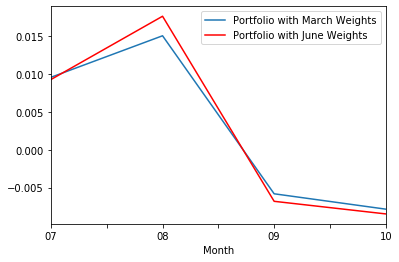

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

ax = plt.gca()

monthly_result.plot(kind='line',x='Month',y='Portfolio with March Weights',ax=ax)
monthly_result.plot(kind='line',x='Month',y='Portfolio with June Weights', color='red', ax=ax)

plt.show()

In [84]:
monthly_result = pd.concat([optimal_sd_march,optimal_sd_june['Monthly_sd']],axis=1)
monthly_result.columns = ["Month","Portfolio with March Weights", "Portfolio with June Weights"]
#monthly_result = monthly_result.reset_index()
monthly_result

,Month,Portfolio with March Weights,Portfolio with June Weights
0,07,0.035591,0.036668
1,08,0.030959,0.037428
2,09,0.048702,0.055435
3,10,0.044183,0.049807


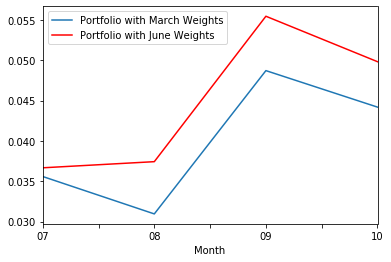

In [85]:
ax = plt.gca()

monthly_result.plot(kind='line',x='Month',y='Portfolio with March Weights',ax=ax)
monthly_result.plot(kind='line',x='Month',y='Portfolio with June Weights', color='red', ax=ax)

plt.show()

# Point 4: Hedging Data Exploration

In [86]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas_datareader.data import DataReader

from requests import get
from bs4 import BeautifulSoup
from datetime import datetime

In [87]:
options = pd.read_csv('VGT_Vanguard Information Technology ETF.csv')

In [88]:
options.head()

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,sic,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag
0,120145,2019/12/31,VGT 200117C225000,1,2020/01/17,2019/12/18,C,225000,16.00,22.3,...,6722,0,1,NaN,%,426,VANGUARD WORLD FDS,NaN,A,0
1,120145,2019/12/31,VGT 200117C230000,1,2020/01/17,NaN,C,230000,11.10,17.1,...,6722,0,1,NaN,%,426,VANGUARD WORLD FDS,NaN,A,0
2,120145,2019/12/31,VGT 200117C235000,1,2020/01/17,2019/12/02,C,235000,6.50,11.6,...,6722,0,1,NaN,%,426,VANGUARD WORLD FDS,NaN,A,0
3,120145,2019/12/31,VGT 200117C240000,1,2020/01/17,2019/12/23,C,240000,2.30,9.6,...,6722,0,1,NaN,%,426,VANGUARD WORLD FDS,NaN,A,0
4,120145,2019/12/31,VGT 200117C245000,1,2020/01/17,2019/12/31,C,245000,2.55,3.8,...,6722,0,1,NaN,%,426,VANGUARD WORLD FDS,NaN,A,0


In [89]:
options.columns

Index(['secid', 'date', 'symbol', 'symbol_flag', 'exdate', 'last_date',
       'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume',
       'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
       'optionid', 'cfadj', 'am_settlement', 'contract_size', 'ss_flag',
       'forward_price', 'expiry_indicator', 'root', 'suffix', 'cusip',
       'ticker', 'sic', 'index_flag', 'exchange_d', 'class', 'issue_type',
       'industry_group', 'issuer', 'div_convention', 'exercise_style',
       'am_set_flag'],
      dtype='object')

## Expiration Dates

In [90]:
options.loc[options["cp_flag"] == "P"]["exdate"].unique()

array(['2020/01/17', '2020/02/21', '2020/05/15', '2020/08/21'],
      dtype=object)

In [91]:
options.loc[options["cp_flag"] == "C"]["exdate"].unique()

array(['2020/01/17', '2020/02/21', '2020/05/15', '2020/08/21'],
      dtype=object)

## Strike Prices

In [92]:
options['strike_price'] = options['strike_price']/1000
options.loc[options["cp_flag"] == "P"]["strike_price"].unique()

array([225., 230., 235., 240., 245., 250., 200., 205., 210., 215., 220.,
       260., 270., 280., 290., 300., 255., 265., 275., 285., 295.])

In [93]:
options.loc[options["cp_flag"] == "C"]["strike_price"].unique()

array([225., 230., 235., 240., 245., 250., 200., 205., 210., 215., 220.,
       260., 270., 280., 290., 300., 255., 265., 275., 285., 295.])

## Index Price on 31 Dec 2019

In [94]:
index = get_adj_close_for_multiple_stocks(["VGT"], start_date = "2019-12-31", end_date = "2019-12-31")
index = index.reset_index()
index

,Date,VGT
0,2019-12-30,242.067215
1,2019-12-31,242.731445


# Hedging

In [95]:
def get_data_for_multiple_stocks(tickers,start_date='2020-01-01',end_date= '2020-08-31'):
    #define helper function here
    stocks = dict()
    # loop through all the tickers
    for ticker in tickers:
        
        # get the data for the specific ticker
        s = DataReader(ticker, 'yahoo', start_date, end_date)
       
        s.insert(0, "Ticker", ticker)  #insert ticker column so you can reference better later
        
        s['Prev Close'] = s['Adj Close'].shift(1)
        s['log_return'] = np.log(s['Adj Close']/s['Prev Close'])
        s['perc_return'] = (s['Adj Close']/s['Prev Close'])
        # add it to the dictionary
        stocks[ticker] = s
    # return the dictionary
    return stocks

**Using available capital, find out how much to invest in stock**


In [96]:
tickers = ["AAPL", "VZ", "AMT", "GOOG", 
           "MRVL", "ATVI", "ERCA.BE", "RNG", 
           "MU", "LPSN", "CHA", "IRDM", "MSI", "NOK"]

In [97]:
portfolio_weights = [0.0669394429696608, 0.0156167963228005,0.1062772839675684,0.0507895810608006,
                    0.0087579558669224,0.025863445845051,0.0594418808164353,
                    0.2,0.0310143978959518,0.2,0.0179250001506637,0.1016139034783358,
                    0.0796658946602216,0.0360944169655878]

In [98]:
capital = 150000
capital_for_each_stock = [i * capital for i in portfolio_weights]
capital_for_each_stock

[10040.91644544912,
 2342.519448420075,
 15941.59259513526,
 7618.43715912009,
 1313.69338003836,
 3879.51687675765,
 8916.282122465294,
 30000.0,
 4652.15968439277,
 30000.0,
 2688.750022599555,
 15242.085521750369,
 11949.88419903324,
 5414.16254483817]

**Get prices of each stock at 31 Dec 2019**

In [99]:
end_year_prices = get_data_for_multiple_stocks(tickers,start_date='2019-12-30',end_date= '2019-12-31')

In [100]:
adj_close_asset = []
for k in end_year_prices:
    price = end_year_prices[k].iloc[-1]['Adj Close']
    adj_close_asset.append(price)

adj_close_asset

[72.19286346435547,
 58.827518463134766,
 226.81011962890625,
 1337.02001953125,
 26.407440185546875,
 59.03175735473633,
 7.744345664978027,
 168.6699981689453,
 53.779998779296875,
 37.0,
 39.16689682006836,
 24.639999389648438,
 159.08094787597656,
 3.7100000381469727]

**Calculate number of shares to buy for each stock**

In [101]:
shares_asset = [math.floor(i/j) for i, j in zip(capital_for_each_stock, adj_close_asset)]      
shares_asset

[139, 39, 70, 5, 49, 65, 1151, 177, 86, 810, 68, 618, 75, 1459]

These number of shares will be fixed and not rebalanced until at the point where the option is exercised and the weights in the portfolio are considered to be rebalanced.

**Portfolio value**

In [102]:
stocks = get_data_for_multiple_stocks(tickers,start_date='2018-01-01',end_date= '2019-12-31')

In [103]:
aapl =  stocks['AAPL']
vz =  stocks['VZ']
amt =  stocks['AMT']
goog =  stocks['GOOG']
marvl =  stocks['MRVL']
atvi =  stocks['ATVI']
ercabe =  stocks['ERCA.BE']
rng =  stocks['RNG']
mu =  stocks['MU']
lpsn = stocks['LPSN']
cha =  stocks['CHA']
irdm = stocks['IRDM']
msi = stocks['MSI']
nok = stocks['NOK']

In [104]:
aapl.head()

,Ticker,High,Low,Open,Close,Volume,Adj Close,Prev Close,log_return,perc_return
Date,,,,,,,,,,
2018-01-02,AAPL,43.075001,42.314999,42.540001,43.064999,102223600.0,41.105534,NaN,NaN,NaN
2018-01-03,AAPL,43.637501,42.990002,43.132500,43.057499,118071600.0,41.098373,41.105534,-0.000174,0.999826
2018-01-04,AAPL,43.367500,43.020000,43.134998,43.257500,89738400.0,41.289268,41.098373,0.004634,1.004645
2018-01-05,AAPL,43.842499,43.262501,43.360001,43.750000,94640000.0,41.759361,41.289268,0.011321,1.011385
2018-01-08,AAPL,43.902500,43.482498,43.587502,43.587502,82271200.0,41.604263,41.759361,-0.003721,0.996286


In [105]:
# Transform Date from integer to date type
aapl = aapl.reset_index()
aapl['Date'] = pd.to_datetime(aapl['Date'], infer_datetime_format=True)

vz = vz.reset_index()
vz['Date'] = pd.to_datetime(vz['Date'], infer_datetime_format=True)

amt = amt.reset_index()
amt['Date'] = pd.to_datetime(amt['Date'], infer_datetime_format=True)

goog = goog.reset_index()
goog['Date'] = pd.to_datetime(goog['Date'], infer_datetime_format=True)

marvl = marvl.reset_index()
marvl['Date'] = pd.to_datetime(marvl['Date'], infer_datetime_format=True)

atvi = atvi.reset_index()
atvi['Date'] = pd.to_datetime(atvi['Date'], infer_datetime_format=True)

ercabe = ercabe.reset_index()
ercabe['Date'] = pd.to_datetime(ercabe['Date'], infer_datetime_format=True)

rng = rng.reset_index()
rng['Date'] = pd.to_datetime(vz['Date'], infer_datetime_format=True)

mu = mu.reset_index()
mu['Date'] = pd.to_datetime(mu['Date'], infer_datetime_format=True)

lpsn = lpsn.reset_index()
lpsn['Date'] = pd.to_datetime(lpsn['Date'], infer_datetime_format=True)

cha = cha.reset_index()
cha['Date'] = pd.to_datetime(cha['Date'], infer_datetime_format=True)

irdm = irdm.reset_index()
irdm['Date'] = pd.to_datetime(irdm['Date'], infer_datetime_format=True)

msi = msi.reset_index()
msi['Date'] = pd.to_datetime(msi['Date'], infer_datetime_format=True)

nok = nok.reset_index()
nok['Date'] = pd.to_datetime(nok['Date'], infer_datetime_format=True)

In [106]:
aapl.head()

,Date,Ticker,High,Low,Open,Close,Volume,Adj Close,Prev Close,log_return,perc_return
0,2018-01-02,AAPL,43.075001,42.314999,42.540001,43.064999,102223600.0,41.105534,NaN,NaN,NaN
1,2018-01-03,AAPL,43.637501,42.990002,43.132500,43.057499,118071600.0,41.098373,41.105534,-0.000174,0.999826
2,2018-01-04,AAPL,43.367500,43.020000,43.134998,43.257500,89738400.0,41.289268,41.098373,0.004634,1.004645
3,2018-01-05,AAPL,43.842499,43.262501,43.360001,43.750000,94640000.0,41.759361,41.289268,0.011321,1.011385
4,2018-01-08,AAPL,43.902500,43.482498,43.587502,43.587502,82271200.0,41.604263,41.759361,-0.003721,0.996286


In [107]:
# Calculate asset values in stock
aapl['Value'] = shares_asset[0] * aapl['Adj Close']
vz['Value'] = shares_asset[1] * vz['Adj Close']
amt['Value'] = shares_asset[2] * amt['Adj Close']
goog['Value'] = shares_asset[3] * goog['Adj Close']
marvl['Value'] = shares_asset[4] * marvl['Adj Close']
atvi['Value'] = shares_asset[5] * atvi['Adj Close']
ercabe['Value'] = shares_asset[6] * ercabe['Adj Close']
rng['Value'] = shares_asset[7] * rng['Adj Close']
mu['Value'] = shares_asset[8] * mu['Adj Close']
lpsn['Value'] = shares_asset[9] * lpsn['Adj Close']
cha['Value'] = shares_asset[10] * cha['Adj Close']
irdm['Value'] = shares_asset[11] * irdm['Adj Close']
msi['Value'] = shares_asset[12] * msi['Adj Close']
nok['Value'] = shares_asset[13] * nok['Adj Close']

In [108]:
#create new dataframe with daily asset value and portfolio value
portfolio = pd.DataFrame(columns = ['Date',"AAPL", "VZ", "AMT", "GOOG", 
           "MRVL", "ATVI", "ERCA.BE", "RNG", 
           "MU", "LPSN", "CHA", "IRDM", "MSI", "NOK",'Value'])

portfolio['Date'] = aapl['Date']
portfolio['AAPL'] = aapl['Value']
portfolio['VZ'] = vz['Value']
portfolio['AMT'] = amt['Value']
portfolio['GOOG'] = goog['Value']
portfolio['MRVL'] = marvl['Value']
portfolio['ATVI'] = atvi['Value']
portfolio['ERCA.BE'] = ercabe['Value']
portfolio['RNG'] = rng['Value']
portfolio['MU'] = mu['Value']
portfolio['LPSN'] = lpsn['Value']
portfolio['CHA'] = cha['Value']
portfolio['IRDM'] = irdm['Value']
portfolio['MSI'] = msi['Value']
portfolio['NOK'] = nok['Value']
portfolio['Value'] = (portfolio['AAPL'] + portfolio['VZ'] + portfolio['AMT'] + portfolio['GOOG'] + 
                      portfolio['MRVL'] + portfolio['ATVI'] + portfolio['ERCA.BE'] + portfolio['RNG'] + 
                      portfolio['MU'] + portfolio['LPSN'] + portfolio['CHA'] + portfolio['IRDM'] + 
                      portfolio['MSI'] + portfolio['NOK'])

In [109]:
portfolio.head()

,Date,AAPL,VZ,AMT,GOOG,MRVL,ATVI,ERCA.BE,RNG,MU,LPSN,CHA,IRDM,MSI,NOK,Value
0,2018-01-02,5713.669170,1832.079094,9372.585144,5325.000000,1056.937836,4098.613453,5905.484126,8460.599865,3755.619843,9396.000309,2918.481277,7168.800236,6487.554359,6532.474864,78023.899576
1,2018-01-03,5712.673904,1794.431293,9409.109344,5412.399902,1089.788307,4162.345657,5834.410500,8496.000000,3868.279961,9436.499691,2912.418854,7261.500000,6441.702461,6628.540650,78460.100526
2,2018-01-04,5739.208321,1800.249664,9271.640778,5432.000122,1114.545603,4120.920258,5887.450904,8372.099865,4031.680092,9598.500309,2916.056412,7385.099882,6495.435905,6710.882952,78875.771066
3,2018-01-05,5804.551216,1796.142929,9331.409302,5511.149902,1095.025623,4229.901581,5887.450904,8416.349865,3938.799934,9760.500154,2930.606384,7446.900118,6582.843590,6752.054102,79483.685606
4,2018-01-08,5782.992599,1793.062283,9431.024933,5534.699707,1103.119173,4246.471939,5993.530616,8611.050270,3917.299934,9760.500154,2934.244202,7446.900118,6650.191498,6697.159467,79902.246893


In [110]:
portfolio_returns = portfolio[['Date','Value']]
portfolio_returns['Prev Value'] = portfolio_returns['Value'].shift(1)
portfolio_returns['log_return'] = np.log(portfolio_returns['Value']/portfolio_returns['Prev Value'])
portfolio_returns.head()

,Date,Value,Prev Value,log_return
0,2018-01-02,78023.899576,NaN,NaN
1,2018-01-03,78460.100526,78023.899576,0.005575
2,2018-01-04,78875.771066,78460.100526,0.005284
3,2018-01-05,79483.685606,78875.771066,0.007678
4,2018-01-08,79902.246893,79483.685606,0.005252


**Historical simulation: 5% Daily VaR**

In [111]:
from copy import deepcopy
portfolio_hs_VaR = deepcopy(portfolio_returns)

for i in range(0, len(portfolio_hs_VaR)):
    past_250 = portfolio_hs_VaR.loc[(i-250):(i-1), 'log_return']
    if len(past_250) == 250:
        portfolio_hs_VaR.loc[i, 'VaR_95'] = past_250.quantile(0.05)       
    else:
        portfolio_hs_VaR.loc[i, 'VaR_95'] = np.NaN

In [112]:
portfolio_hs_VaR.tail()

,Date,Value,Prev Value,log_return,VaR_95
498,2019-12-24,150267.281430,150572.389701,-0.002028,-0.022065
499,2019-12-26,150041.927780,150267.281430,-0.001501,-0.022065
500,2019-12-27,149709.606735,150041.927780,-0.002217,-0.022065
501,2019-12-30,148398.778022,149709.606735,-0.008794,-0.022065
502,2019-12-31,148620.159695,148398.778022,0.001491,-0.022065


In [113]:
portfolio_hs_VaR.dropna(inplace=True)
portfolio_hs_VaR['$VaR'] = portfolio_hs_VaR['Prev Value']*(1-np.exp(portfolio_hs_VaR['VaR_95']))

In [114]:
portfolio_hs_VaR = portfolio_hs_VaR[portfolio_hs_VaR['Date'] > '2018-12-31']
res = portfolio_hs_VaR[["Date", 'VaR_95', '$VaR']]
res.head()

,Date,VaR_95,$VaR
251,2019-01-02,-0.025510,2500.961987
252,2019-01-03,-0.025510,2489.548113
253,2019-01-04,-0.026218,2489.641550
254,2019-01-07,-0.026218,2586.194741
255,2019-01-08,-0.026218,2627.210317


**Value to hedge at end Feb 2020**

In [115]:
var_perc = res.iloc[-1]["VaR_95"]
port_val = portfolio_returns.iloc[-1]["Value"]
var = port_val*(1-math.exp(var_perc)) * math.sqrt(2/12 * 252)
var

21019.76111776339

**Get the US Treasury Rates for 2019 using it as a proxy for Risk-Free Rate**

In [116]:
from requests import get
from bs4 import BeautifulSoup
from datetime import datetime

In [117]:
url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/TextView.aspx?data=billRatesYear&year=2019'

response = get(url)
html_soup = BeautifulSoup(response.text,'html.parser')
risk_free = pd.DataFrame(columns = ["Date","Coupon Equivalent Rate"])
data = html_soup.find_all('td', class_="text_view_data")
date = []
rate = []
n = len(data)
for i in range(0,n):
    if "/" in data[i].text:
        date.append(data[i].text[:-2] + "20"+ data[i].text[-2:] ) # Date
        rate.append(float(data[i+2].text)) #Coupon Equivalent Rate

risk_free = pd.DataFrame(columns = ["Date","Coupon Equivalent Rate"])
risk_free["Date"] = date
risk_free["Coupon Equivalent Rate"] = rate
risk_free

,Date,Coupon Equivalent Rate
0,01/02/2019,2.40
1,01/03/2019,2.42
2,01/04/2019,2.40
3,01/07/2019,2.42
4,01/08/2019,2.40
...,...,...
245,12/24/2019,1.55
246,12/26/2019,1.59
247,12/27/2019,1.56
248,12/30/2019,1.51


In [118]:
risk_free["Coupon Equivalent Rate"] = (risk_free["Coupon Equivalent Rate"] / 100)/ math.sqrt(252)
risk_free['Date'] = pd.to_datetime(risk_free['Date'], infer_datetime_format=True)

In [119]:
risk_free.head()

,Date,Coupon Equivalent Rate
0,2019-01-02,0.001512
1,2019-01-03,0.001524
2,2019-01-04,0.001512
3,2019-01-07,0.001524
4,2019-01-08,0.001512


**Get portfolio & index log returns data. Regress to get beta**

In [120]:
vgt =  get_data_for_multiple_stocks(['VGT'],start_date="2019-01-01", end_date = "2019-12-31")

In [121]:
#vgt's log return
vgt = vgt['VGT']
vgt = vgt.reset_index()
vgt.head()

,Date,Ticker,High,Low,Open,Close,Volume,Adj Close,Prev Close,log_return,perc_return
0,2018-12-31,VGT,167.330002,165.410004,166.610001,166.830002,965900.0,163.320114,NaN,NaN,NaN
1,2019-01-02,VGT,167.770004,163.339996,163.550003,166.929993,861200.0,163.418015,163.320114,0.000599,1.000599
2,2019-01-03,VGT,163.020004,158.500000,162.740005,158.679993,705100.0,155.341583,163.418015,-0.050685,0.950578
3,2019-01-04,VGT,166.350006,161.070007,161.539993,165.580002,731900.0,162.096405,155.341583,0.042565,1.043484
4,2019-01-07,VGT,168.529999,165.500000,165.869995,167.429993,1108000.0,163.907501,162.096405,0.011111,1.011173


In [122]:
#optimal portfolio log returns
optim_port = portfolio_returns[['Date','log_return']]
optim_port = optim_port.rename(columns={"log_return": "optim"})
optim_port = optim_port[optim_port['Date'] > '2018-12-31']
optim_port.head()

,Date,optim
251,2019-01-02,-0.004574
252,2019-01-03,-0.026988
253,2019-01-04,0.038049
254,2019-01-07,0.015735
255,2019-01-08,0.018475


In [123]:
merged = pd.merge(optim_port,vgt[['Date','log_return']], how="left", on=['Date'])
merged = merged.rename(columns={"log_return": "vgt"})

In [124]:
merged = pd.merge(merged, risk_free, how="left", on=['Date'])

In [125]:
merged[merged['Coupon Equivalent Rate'].isnull()]

,Date,optim,vgt,Coupon Equivalent Rate
197,2019-10-14,0.005884,-0.000046,NaN
217,2019-11-11,-0.005224,0.001259,NaN


In [126]:
merged['Coupon Equivalent Rate'] = merged['Coupon Equivalent Rate'].ffill()
merged['Coupon Equivalent Rate'].isnull().sum()

0

In [127]:
#log_returns minus rf rate
headers = list(merged.loc[:,['optim','vgt']])
minus_rf = pd.DataFrame(columns= headers)
for i in headers:
    minus_rf[i] = merged[i] - merged['Coupon Equivalent Rate']
    
minus_rf.head()

,optim,vgt
0,-0.006086,-0.000913
1,-0.028512,-0.052209
2,0.036537,0.041053
3,0.014211,0.009587
4,0.016963,0.008058


In [128]:
import statsmodels.formula.api as smf

results = smf.ols('optim ~ vgt', data=minus_rf).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  optim   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     358.7
Date:                Thu, 12 Nov 2020   Prob (F-statistic):           3.22e-50
Time:                        18:20:13   Log-Likelihood:                 859.81
No. Observations:                 252   AIC:                            -1716.
Df Residuals:                     250   BIC:                            -1709.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.594e-05      0.001      0.131      0.8

In [129]:
beta = 0.8427

The beta computed is 0.8427. This means that the portfolio is 0.8427 times more risky than the index.

**To achieve zero beta, we go "short" 0.8427 of VGT equivalent portfolio dollars since the portfolio is 0.8427x more "risky"**

Using our optimal market portfolio and our VaR was 5 percent, we need to hedge against a 5% drop in the market, therefore we would buy VGT puts 5 percent below current strike price.

Since we have a less riskier portfolio, and the portfolio VaR is 5 percent, buy the VGT puts but except you have to adjust the Put Strike price lower for the VGT (portfolio will fall by a smaller amount, VGT fall by larger amount). Buy VGT with put price 5/0.8427 = 5.93 % lower than current price.

**Find strike price and num of options to buy on 31 Dec 2019**

In [130]:
vgt_price = 244.85
port_val = portfolio_returns.iloc[-1]['Value']

print(f"Value we need to hedge ${var}") 
print(f"Beta value {beta}")
print(f"Portfolio value on 31st Dec 2019 ${port_val}")
print(f"VGT stock price on 31st Dec 2019 ${vgt_price}")

Value we need to hedge $21019.76111776339
Beta value 0.8427
Portfolio value on 31st Dec 2019 $148620.15969467163
VGT stock price on 31st Dec 2019 $244.85


In [131]:
#buy options at this price
option_stock_price = vgt_price * (1- (5/beta)/100)
print(f"Buy options with at strike price ${option_stock_price}")

Buy options with at strike price $230.32229144416755


In [132]:
#number of options to buy
num_options = (port_val * beta)/vgt_price
num_contracts = round(num_options/100)
print(f"Number of options to buy is {num_options}")
print(f"Number of options contract to buy is {num_contracts}")

Number of options to buy is 511.50585490994405
Number of options contract to buy is 5


**Find options to buy on 31 Dec 2019**

In [133]:
options = pd.read_csv("VGT_Vanguard Information Technology ETF.csv")
options = options[['date', 'symbol', 'exdate', 'cp_flag', 'strike_price','best_offer']]
options.head()

,date,symbol,exdate,cp_flag,strike_price,best_offer
0,2019/12/31,VGT 200117C225000,2020/01/17,C,225000,22.3
1,2019/12/31,VGT 200117C230000,2020/01/17,C,230000,17.1
2,2019/12/31,VGT 200117C235000,2020/01/17,C,235000,11.6
3,2019/12/31,VGT 200117C240000,2020/01/17,C,240000,9.6
4,2019/12/31,VGT 200117C245000,2020/01/17,C,245000,3.8


In [134]:
#get put options only
options = options[options['cp_flag'] == 'P']

In [135]:
options['strike_price'] /= 1000
options = options.reset_index()
options.drop(['index'], axis = 1, inplace = True)
options.head()

,date,symbol,exdate,cp_flag,strike_price,best_offer
0,2019/12/31,VGT 200117P225000,2020/01/17,P,225.0,2.30
1,2019/12/31,VGT 200117P230000,2020/01/17,P,230.0,0.55
2,2019/12/31,VGT 200117P235000,2020/01/17,P,235.0,1.20
3,2019/12/31,VGT 200117P240000,2020/01/17,P,240.0,5.80
4,2019/12/31,VGT 200117P245000,2020/01/17,P,245.0,6.00


In [136]:
#filter the choices of options
possible_options = []
for i in range(len(options)):
    if options.iloc[i]['strike_price'] <= option_stock_price:
        possible_options.append(i)

possible_options

[0, 1, 6, 7, 8, 9, 10, 11, 12, 20, 21, 22, 23, 24, 25]

In [137]:
options.iloc[possible_options]

,date,symbol,exdate,cp_flag,strike_price,best_offer
0,2019/12/31,VGT 200117P225000,2020/01/17,P,225.0,2.30
1,2019/12/31,VGT 200117P230000,2020/01/17,P,230.0,0.55
6,2019/12/31,VGT 200221P200000,2020/02/21,P,200.0,1.20
7,2019/12/31,VGT 200221P205000,2020/02/21,P,205.0,1.00
8,2019/12/31,VGT 200221P210000,2020/02/21,P,210.0,1.15
9,2019/12/31,VGT 200221P215000,2020/02/21,P,215.0,5.40
10,2019/12/31,VGT 200221P220000,2020/02/21,P,220.0,2.25
11,2019/12/31,VGT 200221P225000,2020/02/21,P,225.0,1.70
12,2019/12/31,VGT 200221P230000,2020/02/21,P,230.0,6.10
20,2019/12/31,VGT 200515P205000,2020/05/15,P,205.0,2.45


Since we are hedging the stock at the end of February, we will buy VGT 200221P230000 option which expires on 21 Feb 2020 with a strike price of $230 (closest to the calculated).

In [138]:
option_price = options.iloc[12]['best_offer']
option_price

6.1

In [139]:
#use at most 20% portfolio values to buy options
maximum = 0.2*port_val
print(f"Max amount we have to buy put options ${maximum}")

Max amount we have to buy put options $29724.031938934328


In [140]:
#cost needed to buy the options
cost = num_contracts * 100 * option_price
cost

3050.0

**On option expiration date: 21 Feb 2020**

In [141]:
feb_prices = get_data_for_multiple_stocks(tickers,start_date='2020-02-21',end_date= '2020-02-21')

In [142]:
feb_prices['AAPL']

,Ticker,High,Low,Open,Close,Volume,Adj Close,Prev Close,log_return,perc_return
Date,,,,,,,,,,
2020-02-20,AAPL,81.162498,79.552498,80.657501,80.074997,100566000,78.931564,NaN,NaN,NaN
2020-02-21,AAPL,80.112503,77.625000,79.654999,78.262497,129554000,77.144943,78.931564,-0.022895,0.977365


In [143]:
feb_adj_close_asset = []
for k in feb_prices:
    price = feb_prices[k].iloc[-1]['Adj Close']
    feb_adj_close_asset.append(price)

feb_adj_close_asset

[77.14494323730469,
 56.34189224243164,
 243.77496337890625,
 1485.1099853515625,
 24.289676666259766,
 62.965885162353516,
 8.038434982299805,
 235.91000366210938,
 56.9900016784668,
 32.31999969482422,
 38.74850845336914,
 30.200000762939453,
 182.90261840820312,
 4.159999847412109]

In [144]:
#portfolio value on 21 Feb
feb_port_val = [i*j for i, j in zip(shares_asset, feb_adj_close_asset)]      
feb_port_val = sum(feb_port_val)
feb_port_val

165867.53937721252

In [145]:
#vgt stock price on 21 Feb
feb_option_price = 264.68

The put option that we bought has a strike price of 230. However, the VGT stock price on 21 Feb 2020 is higher than the strike price. Therefore, the option worth 0 on the exercise date.

In [146]:
print(f"If we had not hedged the portfolio on 31 Dec 2019, returns is {feb_port_val - capital}")
print(f"Since hedged the portfolio on 31 Dec 2019, returns is {feb_port_val - capital - cost}")

If we had not hedged the portfolio on 31 Dec 2019, returns is 15867.539377212524
Since hedged the portfolio on 31 Dec 2019, returns is 12817.539377212524


# Qn5 Stock Forecasting

In [147]:
def get_data_for_multiple_stocks(tickers, start_date, end_date):
    '''
    Obtain stocks information (Date, OHLC, Volume and Adjusted Close). 
    Uses Pandas DataReader to make an API Call to Yahoo Finance and download the data directly.
    Computes other values - Log Return and Arithmetic Return.
    
    Input: List of Stock Tickers
    Output: A dictionary of dataframes for each stock
    '''
    # read in stock data
    s = DataReader(tickers[0], 'yahoo', start_date, end_date)[["Adj Close"]]
    # get log returns
    s[tickers[0]] = np.log(s['Adj Close']/s['Adj Close'].shift(1))
    
    stocks = s[[tickers[0]]]
    
    for ticker in tickers[1:]:
        s = DataReader(ticker, 'yahoo', start_date, end_date)
        s[ticker] = np.log(s['Adj Close']/s['Adj Close'].shift(1))
        stocks[ticker] = s[ticker]
        
    # skip first row that will be na, and fillna by 0 incase there are trading halts on specific days
    return stocks.iloc[1:].fillna(0)

In [148]:
def get_daily_returns(tickers, start_date, end_date):
    
    '''
    Obtain stocks information (Date, OHLC, Volume and Adjusted Close). 
    Uses Pandas DataReader to make an API Call to Yahoo Finance and download the data directly.
    Computes other values - Log Return and Arithmetic Return.
    
    Input: List of Stock Tickers
    Output: A dictionary of dataframes for each stock
    '''
    # read in stock data
    s = DataReader(tickers[0], 'yahoo', start_date, end_date)[["Adj Close"]]
    

    s[tickers[0]] = s['Adj Close']
    
    stocks = s[[tickers[0]]]
    
    for ticker in tickers[1:]:
        s = DataReader(ticker, 'yahoo', start_date, end_date)
        s[ticker] = s['Adj Close']
        stocks[ticker] = s[ticker]
    
    final = pd.DataFrame(columns = ["Date","Ticker", "Price"])

    for index, row in stocks.iterrows():
        for stock in stocks.columns:
            final = final.append({"Date" : index,"Ticker" : stock , "Price" : row[stock]}, ignore_index= True)

    final['Month'] = final["Date"].apply(lambda x : x.month)
    group1 = pd.DataFrame(final.groupby(["Ticker"]))[1]
    
    temp = pd.DataFrame(columns = ["Date","Ticker", "Daily_Returns"])
    for stock in group1:
        stock = stock.reset_index()
        for daily_entry_index in range(1,len(stock)):
            date = stock["Date"][daily_entry_index]
            prev = stock["Price"][daily_entry_index-1]
            curr = stock["Price"][daily_entry_index]
            ticker = stock["Ticker"][daily_entry_index]
            temp = temp.append({"Date": date,"Ticker" : ticker , "Daily_Returns" : 100*(curr-prev)/prev}, ignore_index= True)

    return temp

In [149]:
def get_average_monthly_volume(tickers, start_date, end_date):

    # read in stock data
    s = DataReader(tickers[0], 'yahoo', start_date, end_date)[["Volume"]]
    

    s[tickers[0]] = s['Volume']
    
    stocks = s[[tickers[0]]]
    
    for ticker in tickers[1:]:
        s = DataReader(ticker, 'yahoo', start_date, end_date)
        #print(s)
        s[ticker] = s['Volume']
        stocks[ticker] = s[ticker]
        #print(stocks)
    
    final = pd.DataFrame(columns = ["Date","Ticker", "Volume"])

    for index, row in stocks.iterrows():
        for stock in stocks.columns:
            final = final.append({"Date" : index,"Ticker" : stock , "Volume" : row[stock]}, ignore_index= True)

    final['Month'] = final["Date"].apply(lambda x : x.month)
    final["Year"]= final["Date"].apply(lambda x : x.year)
    group1 = pd.DataFrame(final.groupby(["Month","Ticker", "Year"]))[1]
    
    temp = pd.DataFrame(columns = ["Date","Ticker", "Monthly_Volume"])
    for daily_entry in group1:
        date = daily_entry["Date"][min(daily_entry["Date"].index)]
        ticker = daily_entry["Ticker"][min(daily_entry["Ticker"].index)]
        
        avg_volume = daily_entry["Volume"].mean()
        
        temp = temp.append({"Date": date,"Ticker" : ticker , "Monthly_Volume" : avg_volume}, ignore_index= True)
    
    return temp

In [150]:
def get_average_monthly_prices(tickers, start_date, end_date):
    # read in stock data
    s = DataReader(tickers[0], 'yahoo', start_date, end_date)[["Adj Close"]]
    

    s[tickers[0]] = s['Adj Close']
    
    stocks = s[[tickers[0]]]
    
    for ticker in tickers[1:]:
        s = DataReader(ticker, 'yahoo', start_date, end_date)
        #print(s)
        s[ticker] = s['Close']
        stocks[ticker] = s[ticker]
        #print(stocks)

    final = pd.DataFrame(columns = ["Date","Ticker", "Price"])

    for index, row in stocks.iterrows():
        for stock in stocks.columns:
            final = final.append({"Date" : index,"Ticker" : stock , "Price" : row[stock]}, ignore_index= True)

    final['Month'] = final["Date"].apply(lambda x : x.month)
    final["Year"]= final["Date"].apply(lambda x : x.year)
    group1 = pd.DataFrame(final.groupby(["Month","Ticker", "Year"]))[1]
    
    temp = pd.DataFrame(columns = ["Date","Ticker", "Monthly_Price"])
    for daily_entry in group1:
        date = daily_entry["Date"][min(daily_entry["Date"].index)]
        ticker = daily_entry["Ticker"][min(daily_entry["Ticker"].index)]
        
        avg_Price = daily_entry["Price"].mean()
        
        temp = temp.append({"Date": date,"Ticker" : ticker , "Monthly_Price" : avg_Price}, ignore_index= True)
    
    return temp

In [151]:
def get_sd_monthly_prices(tickers, start_date, end_date):
    # read in stock data
    s = DataReader(tickers[0], 'yahoo', start_date, end_date)[["Adj Close"]]

    s[tickers[0]] = s['Adj Close']
    
    stocks = s[[tickers[0]]]
    
    for ticker in tickers[1:]:
        s = DataReader(ticker, 'yahoo', start_date, end_date)
        #print(s)
        s[ticker] = s['Close']
        stocks[ticker] = s[ticker]
        #print(stocks)

    final = pd.DataFrame(columns = ["Date","Ticker", "Price"])

    for index, row in stocks.iterrows():
        for stock in stocks.columns:
            final = final.append({"Date" : index,"Ticker" : stock , "Price" : row[stock]}, ignore_index= True)

    final['Month'] = final["Date"].apply(lambda x : x.month)
    final["Year"]= final["Date"].apply(lambda x : x.year)
    group1 = pd.DataFrame(final.groupby(["Month","Ticker", "Year"]))[1]
    
    temp = pd.DataFrame(columns = ["Date","Ticker", "Monthly_Price_SD"])
    for daily_entry in group1:
        date = daily_entry["Date"][min(daily_entry["Date"].index)]
        ticker = daily_entry["Ticker"][min(daily_entry["Ticker"].index)]
        
        sd_Price = daily_entry["Price"].std()
        
        temp = temp.append({"Date": date,"Ticker" : ticker , "Monthly_Price_SD" : sd_Price}, ignore_index= True)
    
    return temp

#### Date column in the dataframe marks the ending date of each period

In [152]:
tickers = ["AAPL", "VZ","AMT", "T", "GOOG",
           "MRVL", "ATVI", "QCOM", "TMUS",
           "ERCA.BE", "VOD", "RNG", "ORA", "MAS",
           "CHL","QRVO", "BCE", "TEF",
           "SWKS", "LBTYA", "MU", "NXPI",
           "LPSN", "CHA", "IRDM", "MSI",
           "ILD.PA", "DISH", "NOK", "USM"]


daily_returns = get_daily_returns(tickers, start_date = "2019-01-02", end_date = "2019-12-31")
daily_returns["Month"] = daily_returns["Date"].apply(lambda x : x.month)
daily_returns

,Date,Ticker,Daily_Returns,Month
0,2019-01-03,AAPL,-9.960744,1
1,2019-01-04,AAPL,4.268926,1
2,2019-01-07,AAPL,-0.222574,1
3,2019-01-08,AAPL,1.906308,1
4,2019-01-09,AAPL,1.698169,1
...,...,...,...,...
7525,2019-12-24,VZ,-0.195451,12
7526,2019-12-26,VZ,0.016315,12
7527,2019-12-27,VZ,0.391584,12
7528,2019-12-30,VZ,-0.520068,12


### Get the US Treasury Rates for 2019 using it as a proxy for Risk-Free Rate

In [153]:
from requests import get
from bs4 import BeautifulSoup
from datetime import datetime

In [154]:
url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/TextView.aspx?data=billRatesYear&year=2019'

response = get(url)
html_soup = BeautifulSoup(response.text,'html.parser')
risk_free = pd.DataFrame(columns = ["Date","Coupon Equivalent Rate"])
data = html_soup.find_all('td', class_="text_view_data")
date = []
rate = []
n = len(data)
for i in range(0,n):
    if "/" in data[i].text:
        date.append(data[i].text[:-2] + "20"+ data[i].text[-2:] ) # Date
        rate.append(float(data[i+2].text)) #Coupon Equivalent Rate

risk_free = pd.DataFrame(columns = ["Date","Coupon Equivalent Rate"])
risk_free["Date"] = date
risk_free["Coupon Equivalent Rate"] = rate

risk_free["Date"] = risk_free["Date"].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').date())
risk_free["Date"] = pd.to_datetime(risk_free["Date"])
risk_free["Month"] = risk_free["Date"].apply(lambda x:x.month)

#Converting annual rate to monthly rate
risk_free["Coupon Equivalent Rate"] = risk_free["Coupon Equivalent Rate"].apply(lambda x : x/math.sqrt(12))

risk_free

,Date,Coupon Equivalent Rate,Month
0,2019-01-02,0.692820,1
1,2019-01-03,0.698594,1
2,2019-01-04,0.692820,1
3,2019-01-07,0.698594,1
4,2019-01-08,0.692820,1
...,...,...,...
245,2019-12-24,0.447446,12
246,2019-12-26,0.458993,12
247,2019-12-27,0.450333,12
248,2019-12-30,0.435899,12


### Merging the Datasets

In [155]:
merge_data = pd.merge(daily_returns, risk_free, how='left', on=['Date','Month'])
merge_data['RET_RF'] = merge_data['Daily_Returns'] - merge_data['Coupon Equivalent Rate']
merge_data

,Date,Ticker,Daily_Returns,Month,Coupon Equivalent Rate,RET_RF
0,2019-01-03,AAPL,-9.960744,1,0.698594,-10.659338
1,2019-01-04,AAPL,4.268926,1,0.692820,3.576106
2,2019-01-07,AAPL,-0.222574,1,0.698594,-0.921168
3,2019-01-08,AAPL,1.906308,1,0.692820,1.213488
4,2019-01-09,AAPL,1.698169,1,0.692820,1.005349
...,...,...,...,...,...,...
7525,2019-12-24,VZ,-0.195451,12,0.447446,-0.642897
7526,2019-12-26,VZ,0.016315,12,0.458993,-0.442679
7527,2019-12-27,VZ,0.391584,12,0.450333,-0.058750
7528,2019-12-30,VZ,-0.520068,12,0.435899,-0.955968


### Getting Index Returns

In [156]:
index = ['VGT']
index_returns = get_daily_returns(index, start_date = "2019-01-02", end_date = "2019-12-31")
index_returns["Month"] = index_returns["Date"].apply(lambda x : x.month)
index_returns

,Date,Ticker,Daily_Returns,Month
0,2019-01-03,VGT,-4.942192,1
1,2019-01-04,VGT,4.348367,1
2,2019-01-07,VGT,1.117296,1
3,2019-01-08,VGT,0.961586,1
4,2019-01-09,VGT,1.248237,1
...,...,...,...,...
246,2019-12-24,VGT,0.008206,12
247,2019-12-26,VGT,0.770962,12
248,2019-12-27,VGT,-0.036631,12
249,2019-12-30,VGT,-0.594368,12


#### Merging Datasets

In [157]:
merge_data = merge_data.merge(index_returns, how='inner', left_on=['Month',"Date"], right_on=['Month',"Date"])
merge_data

,Date,Ticker_x,Daily_Returns_x,Month,Coupon Equivalent Rate,RET_RF,Ticker_y,Daily_Returns_y
0,2019-01-03,AAPL,-9.960744,1,0.698594,-10.659338,VGT,-4.942192
1,2019-01-03,AMT,0.599698,1,0.698594,-0.098896,VGT,-4.942192
2,2019-01-03,ATVI,-3.550923,1,0.698594,-4.249517,VGT,-4.942192
3,2019-01-03,BCE,0.754899,1,0.698594,0.056305,VGT,-4.942192
4,2019-01-03,CHA,-2.114621,1,0.698594,-2.813215,VGT,-4.942192
...,...,...,...,...,...,...,...,...
7525,2019-12-31,TEF,-1.553680,12,0.427239,-1.980919,VGT,0.274399
7526,2019-12-31,TMUS,0.435446,12,0.427239,0.008207,VGT,0.274399
7527,2019-12-31,USM,2.518391,12,0.427239,2.091152,VGT,0.274399
7528,2019-12-31,VOD,-0.051711,12,0.427239,-0.478950,VGT,0.274399


### Computing Index Returns on each Stock less the Risk - Free Rate

In [158]:
merge_data['Mkt_RF'] = merge_data['Daily_Returns_y'] - merge_data['Coupon Equivalent Rate']
merge_data

,Date,Ticker_x,Daily_Returns_x,Month,Coupon Equivalent Rate,RET_RF,Ticker_y,Daily_Returns_y,Mkt_RF
0,2019-01-03,AAPL,-9.960744,1,0.698594,-10.659338,VGT,-4.942192,-5.640785
1,2019-01-03,AMT,0.599698,1,0.698594,-0.098896,VGT,-4.942192,-5.640785
2,2019-01-03,ATVI,-3.550923,1,0.698594,-4.249517,VGT,-4.942192,-5.640785
3,2019-01-03,BCE,0.754899,1,0.698594,0.056305,VGT,-4.942192,-5.640785
4,2019-01-03,CHA,-2.114621,1,0.698594,-2.813215,VGT,-4.942192,-5.640785
...,...,...,...,...,...,...,...,...,...
7525,2019-12-31,TEF,-1.553680,12,0.427239,-1.980919,VGT,0.274399,-0.152840
7526,2019-12-31,TMUS,0.435446,12,0.427239,0.008207,VGT,0.274399,-0.152840
7527,2019-12-31,USM,2.518391,12,0.427239,2.091152,VGT,0.274399,-0.152840
7528,2019-12-31,VOD,-0.051711,12,0.427239,-0.478950,VGT,0.274399,-0.152840


In [159]:
merge_data = merge_data[['Date','Month','Ticker_x','RET_RF','Mkt_RF']]
## Column renaming for convenience
merge_data["Ticker"] = merge_data['Ticker_x']
merge_data = merge_data[['Date','Month','Ticker','RET_RF','Mkt_RF']]

#### Adding constant as the "alpha" Term

In [160]:
merge_data = sm.add_constant(merge_data)
merge_data = merge_data.dropna()
merge_data

,const,Date,Month,Ticker,RET_RF,Mkt_RF
0,1.0,2019-01-03,1,AAPL,-10.659338,-5.640785
1,1.0,2019-01-03,1,AMT,-0.098896,-5.640785
2,1.0,2019-01-03,1,ATVI,-4.249517,-5.640785
3,1.0,2019-01-03,1,BCE,0.056305,-5.640785
4,1.0,2019-01-03,1,CHA,-2.813215,-5.640785
...,...,...,...,...,...,...
7525,1.0,2019-12-31,12,TEF,-1.980919,-0.152840
7526,1.0,2019-12-31,12,TMUS,0.008207,-0.152840
7527,1.0,2019-12-31,12,USM,2.091152,-0.152840
7528,1.0,2019-12-31,12,VOD,-0.478950,-0.152840


#### Run ols to determine alpha

In [161]:
def ols_reg(df, features,  output):
    return sm.OLS(df[output], df[features]).fit()

In [162]:
result = merge_data.groupby(["Ticker","Month"]).apply(ols_reg, features=['const','Mkt_RF'], output='RET_RF')
coef_alpha = [item.params[0] for item in result]
coef_beta = [item.params[1] for item in result]

computed = pd.DataFrame()
computed["Alpha"] = coef_alpha
computed["Beta"] = coef_beta
computed["Stock_Month"] = list(pd.DataFrame(merge_data.groupby(["Ticker","Month"]))[0])
computed["Ticker"] = computed["Stock_Month"].apply(lambda x : x[0])
computed["Month"] = computed["Stock_Month"].apply(lambda x : x[1])
computed

,Alpha,Beta,Stock_Month,Ticker,Month
0,0.081847,1.568252,"(AAPL, 1)",AAPL,1
1,-0.049939,1.274645,"(AAPL, 2)",AAPL,2
2,0.287646,1.062733,"(AAPL, 3)",AAPL,3
3,-0.080465,0.874950,"(AAPL, 4)",AAPL,4
4,0.075268,1.218354,"(AAPL, 5)",AAPL,5
...,...,...,...,...,...
355,-0.155580,0.303143,"(VZ, 8)",VZ,8
356,-0.332300,0.107092,"(VZ, 9)",VZ,9
357,-0.319704,0.293801,"(VZ, 10)",VZ,10
358,-0.549988,-0.296013,"(VZ, 11)",VZ,11


### Labelling for Postive Alpha

In [163]:
computed["Positive_alpha"] = np.where(computed['Alpha']>0, 1, 0)
computed

,Alpha,Beta,Stock_Month,Ticker,Month,Positive_alpha
0,0.081847,1.568252,"(AAPL, 1)",AAPL,1,1
1,-0.049939,1.274645,"(AAPL, 2)",AAPL,2,0
2,0.287646,1.062733,"(AAPL, 3)",AAPL,3,1
3,-0.080465,0.874950,"(AAPL, 4)",AAPL,4,0
4,0.075268,1.218354,"(AAPL, 5)",AAPL,5,1
...,...,...,...,...,...,...
355,-0.155580,0.303143,"(VZ, 8)",VZ,8,0
356,-0.332300,0.107092,"(VZ, 9)",VZ,9,0
357,-0.319704,0.293801,"(VZ, 10)",VZ,10,0
358,-0.549988,-0.296013,"(VZ, 11)",VZ,11,0


### Get the Average Volume of Stocks traded in the previous Period
Volume of stocks traded (1 Jan 2020 - 1 Feb 2020) to predict for the period starting on 1 Feb if the stock will have a positive alpha

In [164]:
#Apply 1 month lag average volume of previous period used to predict the alpha of coming period
volume = get_average_monthly_volume(tickers, start_date = "2019-01-02", end_date = "2019-12-31")
volume["Month"] = volume["Date"].apply(lambda x : x.month)
volume

,Date,Ticker,Monthly_Volume,Month
0,2019-01-02,AAPL,1.577309e+08,1
1,2019-01-02,AMT,1.891086e+06,1
2,2019-01-02,ATVI,9.839533e+06,1
3,2019-01-02,BCE,1.072381e+06,1
4,2019-01-02,CHA,3.872381e+04,1
...,...,...,...,...
355,2019-12-02,TEF,1.711133e+06,12
356,2019-12-02,TMUS,2.751219e+06,12
357,2019-12-02,USM,1.703429e+05,12
358,2019-12-02,VOD,3.091281e+06,12


### Get the Average Price of Stocks traded in the previous Period

In [165]:
#Apply 1 month lag average price of stock of previous period used to predict the alpha of coming period
average_price = get_average_monthly_prices(tickers, start_date = "2019-01-02", end_date = "2019-12-31")
average_price["Month"] = average_price["Date"].apply(lambda x : x.month)
average_price

,Date,Ticker,Monthly_Price,Month
0,2019-01-02,AAPL,37.340200,1
1,2019-01-02,AMT,163.698093,1
2,2019-01-02,ATVI,47.533810,1
3,2019-01-02,BCE,41.657143,1
4,2019-01-02,CHA,52.653809,1
...,...,...,...,...
355,2019-12-02,TEF,7.331905,12
356,2019-12-02,TMUS,76.754762,12
357,2019-12-02,USM,34.704286,12
358,2019-12-02,VOD,19.261429,12


### Get the SD of Price of Stocks traded

In [166]:
sd_price = get_sd_monthly_prices(tickers, start_date = "2019-01-02", end_date = "2019-12-31")
sd_price["Month"] = average_price["Date"].apply(lambda x : x.month)
sd_price

,Date,Ticker,Monthly_Price_SD,Month
0,2019-01-02,AAPL,1.293727,1
1,2019-01-02,AMT,4.336417,1
2,2019-01-02,ATVI,1.557143,1
3,2019-01-02,BCE,1.014284,1
4,2019-01-02,CHA,1.962235,1
...,...,...,...,...
355,2019-12-02,TEF,0.186671,12
356,2019-12-02,TMUS,1.203705,12
357,2019-12-02,USM,0.646603,12
358,2019-12-02,VOD,0.292255,12


### Compute the Risk-Free rate at the end of every month

In [167]:
## Get the Risk-free rate at the start of each month
risk_free_monthly = pd.DataFrame(risk_free["Coupon Equivalent Rate"].groupby(risk_free["Month"]))
risk_free_at_day1_month = pd.DataFrame(columns = ["Month", "Coupon Equivalent Rate"])
start_index = 0
end_index = 0
rates = []
for daily_rates in risk_free_monthly[1].tolist():
    rates.append(daily_rates[start_index])
    end_index = max(daily_rates.index)
    start_index = end_index +1

risk_free_at_day1_month["Coupon Equivalent Rate"] = rates
risk_free_at_day1_month["Month"] = risk_free_monthly[0]
risk_free_at_day1_month["Coupon Equivalent Rate"] = risk_free_at_day1_month["Coupon Equivalent Rate"]
risk_free_at_day1_month

,Month,Coupon Equivalent Rate
0,1,0.692820
1,2,0.695707
2,3,0.704367
3,4,0.698594
4,5,0.698594
5,6,0.681273
6,7,0.626425
7,8,0.609105
8,9,0.597558
9,10,0.516728


### Compute the average daily returns of any specific stock for each month

In [168]:
monthly_returns = pd.DataFrame(daily_returns.groupby(["Ticker","Month"])["Daily_Returns"].mean()).reset_index()
monthly_returns["Stock_Average_Daily_Returns"] = monthly_returns["Daily_Returns"]
monthly_returns = monthly_returns[["Ticker","Month","Stock_Average_Daily_Returns"]]

monthly_returns

,Ticker,Month,Stock_Average_Daily_Returns
0,AAPL,1,0.313740
1,AAPL,2,0.235687
2,AAPL,3,0.451205
3,AAPL,4,0.265714
4,AAPL,5,-0.579528
...,...,...,...
355,VZ,8,0.235384
356,VZ,9,0.187653
357,VZ,10,0.055977
358,VZ,11,-0.016935


### Compute the number of positive and negative daily returns for any specific stock for each month

In [169]:
pos_neg_stock_returns= pd.DataFrame(daily_returns.groupby(["Ticker","Month"]).Daily_Returns.apply(lambda x: pd.Series([(x < 0).sum(), (x >= 0).sum()])).unstack())
pos_neg_stock_returns = pos_neg_stock_returns.reset_index()
pos_neg_stock_returns["Stock_Negative_Daily_Returns_Count"] = pos_neg_stock_returns[0]
pos_neg_stock_returns["Stock_Postive_Daily_Returns_Count"] = pos_neg_stock_returns[1]
pos_neg_stock_returns = pos_neg_stock_returns[["Stock_Negative_Daily_Returns_Count","Stock_Postive_Daily_Returns_Count",
                                              "Ticker","Month"]]
pos_neg_stock_returns

,Stock_Negative_Daily_Returns_Count,Stock_Postive_Daily_Returns_Count,Ticker,Month
0,8,12,AAPL,1
1,6,13,AAPL,2
2,7,14,AAPL,3
3,7,14,AAPL,4
4,15,7,AAPL,5
...,...,...,...,...
355,9,13,VZ,8
356,7,13,VZ,9
357,10,13,VZ,10
358,9,11,VZ,11


### Compute the average daily returns for all months of the index

In [170]:
index_monthly_returns = pd.DataFrame(index_returns.groupby(["Month"])["Daily_Returns"].mean()).reset_index()
index_monthly_returns["Index_Average_Daily_Returns"] = index_monthly_returns["Daily_Returns"]
index_monthly_returns = index_monthly_returns[["Month","Index_Average_Daily_Returns"]]
index_monthly_returns

,Month,Index_Average_Daily_Returns
0,1,0.398961
1,2,0.374934
2,3,0.195686
3,4,0.295615
4,5,-0.413487
5,6,0.428492
6,7,0.160806
7,8,-0.084852
8,9,0.070268
9,10,0.166563


### Compute the number of positive and negative daily returns for index for each month

In [171]:
pos_neg_index_returns= pd.DataFrame(index_returns.groupby(["Month"]).Daily_Returns.apply(lambda x: pd.Series([(x < 0).sum(), (x >= 0).sum()])).unstack())
pos_neg_index_returns = pos_neg_index_returns.reset_index()
pos_neg_index_returns["Index_Negative_Daily_Returns_Count"] = pos_neg_index_returns[0]
pos_neg_index_returns["Index_Postive_Daily_Returns_Count"] = pos_neg_index_returns[1]
pos_neg_index_returns = pos_neg_index_returns[["Index_Negative_Daily_Returns_Count","Index_Postive_Daily_Returns_Count"
                                              ,"Month"]]
pos_neg_index_returns

,Index_Negative_Daily_Returns_Count,Index_Postive_Daily_Returns_Count,Month
0,6,14,1
1,3,16,2
2,8,13,3
3,5,16,4
4,14,8,5
5,7,13,6
6,9,13,7
7,12,10,8
8,9,11,9
9,11,12,10


### Merging of all Data

### Apply Lag ( Use time = t-1 features to predict alpha at time = t)

In [172]:
temp = computed[["Month", "Ticker","Positive_alpha"]]
temp["Month"] = temp["Month"].apply(lambda x: x-1)
## Renaming columns to avoid confusion
temp["Next_Period_Positive_Alpha"] = temp["Positive_alpha"]
temp = temp[["Month", "Ticker","Next_Period_Positive_Alpha"]]
temp

,Month,Ticker,Next_Period_Positive_Alpha
0,0,AAPL,1
1,1,AAPL,0
2,2,AAPL,1
3,3,AAPL,0
4,4,AAPL,1
...,...,...,...
355,7,VZ,0
356,8,VZ,0
357,9,VZ,0
358,10,VZ,0


In [173]:
train_data = computed.merge(temp, how='inner', left_on=["Month","Ticker"], right_on=["Month","Ticker"])
train_data

,Alpha,Beta,Stock_Month,Ticker,Month,Positive_alpha,Next_Period_Positive_Alpha
0,0.081847,1.568252,"(AAPL, 1)",AAPL,1,1,0
1,-0.049939,1.274645,"(AAPL, 2)",AAPL,2,0,1
2,0.287646,1.062733,"(AAPL, 3)",AAPL,3,1,0
3,-0.080465,0.874950,"(AAPL, 4)",AAPL,4,0,1
4,0.075268,1.218354,"(AAPL, 5)",AAPL,5,1,1
...,...,...,...,...,...,...,...
325,-0.515179,0.440139,"(VZ, 7)",VZ,7,0,0
326,-0.155580,0.303143,"(VZ, 8)",VZ,8,0,0
327,-0.332300,0.107092,"(VZ, 9)",VZ,9,0,0
328,-0.319704,0.293801,"(VZ, 10)",VZ,10,0,0


In [174]:
train_data = train_data.merge(volume, how='inner', left_on=["Ticker", "Month"], right_on=["Ticker","Month"])
train_data = train_data.merge(average_price, how='inner', left_on=["Ticker", "Month"], right_on=["Ticker","Month"])
train_data = train_data.merge(sd_price, how='inner', left_on=["Ticker", "Month"], right_on=["Ticker","Month"])

train_data = train_data.merge(risk_free_at_day1_month, how='inner', left_on=["Month"], right_on=["Month"])

train_data = train_data.merge(monthly_returns, how='inner', left_on=["Ticker", "Month"], right_on=["Ticker","Month"])
train_data = train_data.merge(index_monthly_returns, how='inner', left_on=["Month"], right_on=["Month"])

train_data = train_data.merge(pos_neg_stock_returns, how='inner', left_on=["Ticker", "Month"], right_on=["Ticker","Month"])
train_data = train_data.merge(pos_neg_index_returns, how='inner', left_on=["Month"], right_on=["Month"])

train_data

,Alpha,Beta,Stock_Month,Ticker,Month,Positive_alpha,Next_Period_Positive_Alpha,Date_x,Monthly_Volume,Date_y,Monthly_Price,Date,Monthly_Price_SD,Coupon Equivalent Rate,Stock_Average_Daily_Returns,Index_Average_Daily_Returns,Stock_Negative_Daily_Returns_Count,Stock_Postive_Daily_Returns_Count,Index_Negative_Daily_Returns_Count,Index_Postive_Daily_Returns_Count
0,0.081847,1.568252,"(AAPL, 1)",AAPL,1,1,0,2019-01-02,1.577309e+08,2019-01-02,37.340200,2019-01-02,1.293727,0.692820,0.313740,0.398961,8,12,6,14
1,-0.198064,0.011130,"(AMT, 1)",AMT,1,0,0,2019-01-02,1.891086e+06,2019-01-02,163.698093,2019-01-02,4.336417,0.692820,0.491629,0.398961,3,17,6,14
2,-0.344801,0.943719,"(ATVI, 1)",ATVI,1,0,0,2019-01-02,9.839533e+06,2019-01-02,47.533810,2019-01-02,1.557143,0.692820,0.070707,0.398961,7,13,6,14
3,-0.235629,0.007522,"(BCE, 1)",BCE,1,0,0,2019-01-02,1.072381e+06,2019-01-02,41.657143,2019-01-02,1.014284,0.692820,0.455124,0.398961,5,15,6,14
4,-0.191118,0.359901,"(CHA, 1)",CHA,1,0,0,2019-01-02,3.872381e+04,2019-01-02,52.653809,2019-01-02,1.962235,0.692820,0.396034,0.398961,9,11,6,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,-0.481258,0.260772,"(TEF, 11)",TEF,11,0,0,2019-11-01,1.708415e+06,2019-11-01,7.490500,2019-11-01,0.100811,0.456107,-0.026560,0.273936,10,10,7,13
326,-0.675859,-0.245118,"(TMUS, 11)",TMUS,11,0,0,2019-11-01,2.861800e+06,2019-11-01,79.135500,2019-11-01,1.781178,0.456107,-0.248441,0.273936,9,11,7,13
327,-1.147176,-1.741457,"(USM, 11)",USM,11,0,1,2019-11-01,2.809550e+05,2019-11-01,34.234500,2019-11-01,1.070261,0.456107,-0.359573,0.273936,10,10,7,13
328,-0.360524,0.422377,"(VOD, 11)",VOD,11,0,0,2019-11-01,3.149430e+06,2019-11-01,20.334000,2019-11-01,0.513486,0.456107,-0.012434,0.273936,8,12,7,13


### Selecting the relevant columns

In [175]:
train_data = train_data[["Month","Ticker", "Alpha", "Beta", "Monthly_Volume", 
                         "Monthly_Price", "Monthly_Price_SD","Positive_alpha", "Coupon Equivalent Rate",
                        "Stock_Average_Daily_Returns","Index_Average_Daily_Returns",
                         "Stock_Negative_Daily_Returns_Count","Stock_Postive_Daily_Returns_Count",
                         "Index_Negative_Daily_Returns_Count", "Index_Postive_Daily_Returns_Count",
                         "Next_Period_Positive_Alpha"]]
train_data

,Month,Ticker,Alpha,Beta,Monthly_Volume,Monthly_Price,Monthly_Price_SD,Positive_alpha,Coupon Equivalent Rate,Stock_Average_Daily_Returns,Index_Average_Daily_Returns,Stock_Negative_Daily_Returns_Count,Stock_Postive_Daily_Returns_Count,Index_Negative_Daily_Returns_Count,Index_Postive_Daily_Returns_Count,Next_Period_Positive_Alpha
0,1,AAPL,0.081847,1.568252,1.577309e+08,37.340200,1.293727,1,0.692820,0.313740,0.398961,8,12,6,14,0
1,1,AMT,-0.198064,0.011130,1.891086e+06,163.698093,4.336417,0,0.692820,0.491629,0.398961,3,17,6,14,0
2,1,ATVI,-0.344801,0.943719,9.839533e+06,47.533810,1.557143,0,0.692820,0.070707,0.398961,7,13,6,14,0
3,1,BCE,-0.235629,0.007522,1.072381e+06,41.657143,1.014284,0,0.692820,0.455124,0.398961,5,15,6,14,0
4,1,CHA,-0.191118,0.359901,3.872381e+04,52.653809,1.962235,0,0.692820,0.396034,0.398961,9,11,6,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,11,TEF,-0.481258,0.260772,1.708415e+06,7.490500,0.100811,0,0.456107,-0.026560,0.273936,10,10,7,13,0
326,11,TMUS,-0.675859,-0.245118,2.861800e+06,79.135500,1.781178,0,0.456107,-0.248441,0.273936,9,11,7,13,0
327,11,USM,-1.147176,-1.741457,2.809550e+05,34.234500,1.070261,0,0.456107,-0.359573,0.273936,10,10,7,13,1
328,11,VOD,-0.360524,0.422377,3.149430e+06,20.334000,0.513486,0,0.456107,-0.012434,0.273936,8,12,7,13,0


### Data Exploration

In [176]:
import matplotlib.pyplot as plt

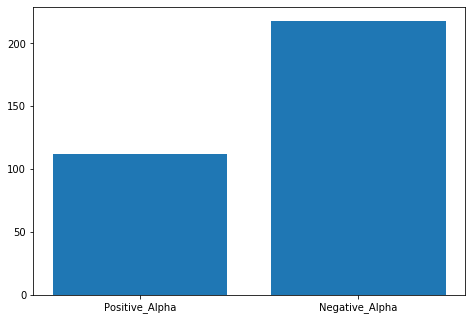

Number of Positive_Alpha:  112
Number of Negative_Alpha:  218


In [177]:
positive = len(train_data[train_data["Next_Period_Positive_Alpha"] == 1].index)
negative = len(train_data[train_data["Next_Period_Positive_Alpha"] == 0].index)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = ['Positive_Alpha', 'Negative_Alpha']
status = [positive,negative]
ax.bar(lab,status)
plt.show()
print("Number of Positive_Alpha: ", positive)
print("Number of Negative_Alpha: ", negative)

### Training of XGBoost Model

In [178]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay, classification_report, auc, roc_curve
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef
from xgboost import XGBClassifier

### Apply One-Hot encoding for tickers

In [179]:
#One-hot-encoding on Ticker: 
categorical = ['Ticker']
ticks = pd.get_dummies(train_data['Ticker']) 
train_data = train_data.drop(categorical, axis=1)
train_data = train_data.join([ticks])
train_data

,Month,Alpha,Beta,Monthly_Volume,Monthly_Price,Monthly_Price_SD,Positive_alpha,Coupon Equivalent Rate,Stock_Average_Daily_Returns,Index_Average_Daily_Returns,...,QCOM,QRVO,RNG,SWKS,T,TEF,TMUS,USM,VOD,VZ
0,1,0.081847,1.568252,1.577309e+08,37.340200,1.293727,1,0.692820,0.313740,0.398961,...,0,0,0,0,0,0,0,0,0,0
1,1,-0.198064,0.011130,1.891086e+06,163.698093,4.336417,0,0.692820,0.491629,0.398961,...,0,0,0,0,0,0,0,0,0,0
2,1,-0.344801,0.943719,9.839533e+06,47.533810,1.557143,0,0.692820,0.070707,0.398961,...,0,0,0,0,0,0,0,0,0,0
3,1,-0.235629,0.007522,1.072381e+06,41.657143,1.014284,0,0.692820,0.455124,0.398961,...,0,0,0,0,0,0,0,0,0,0
4,1,-0.191118,0.359901,3.872381e+04,52.653809,1.962235,0,0.692820,0.396034,0.398961,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,11,-0.481258,0.260772,1.708415e+06,7.490500,0.100811,0,0.456107,-0.026560,0.273936,...,0,0,0,0,0,1,0,0,0,0
326,11,-0.675859,-0.245118,2.861800e+06,79.135500,1.781178,0,0.456107,-0.248441,0.273936,...,0,0,0,0,0,0,1,0,0,0
327,11,-1.147176,-1.741457,2.809550e+05,34.234500,1.070261,0,0.456107,-0.359573,0.273936,...,0,0,0,0,0,0,0,1,0,0
328,11,-0.360524,0.422377,3.149430e+06,20.334000,0.513486,0,0.456107,-0.012434,0.273936,...,0,0,0,0,0,0,0,0,1,0


### Splitting Data to training and validation

In [180]:
training_data = train_data[train_data["Month"]< 10]
validation_data = train_data[train_data["Month"]>= 10]

print("Size of training data: ", len(training_data))
print("Size of validation data: ", len(validation_data))

Size of training data:  270
Size of validation data:  60


In [181]:
training_data_input_features = training_data.loc[:, training_data.columns != 'Next_Period_Positive_Alpha']
target = training_data["Next_Period_Positive_Alpha"]

validation_input_features = validation_data.loc[:, validation_data.columns != 'Next_Period_Positive_Alpha']
validation_target = validation_data["Next_Period_Positive_Alpha"]

### Tuning Model HyperParameters

In [182]:
import os,pickle
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from time import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_curve, auc, matthews_corrcoef, make_scorer, confusion_matrix, precision_score, recall_score, f1_score

In [183]:
def save_file(path, data):
    output = open(path, 'wb')
    pickle.dump(data, output)
    output.close()

def load_file(path):
    pkl_file = open(path, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

In [184]:
if not os.path.exists('Tuning'): os.mkdir('Tuning')
    
def compute_fold_acc(classifier, X_train, y_train, X_test, y_test,tuning_params):
    results = {}
    for feature in tqdm(tuning_params):
        accuracy = []
        for param in tuning_params[feature]:
            clf = classifier(**{feature:param}, random_state=1)
            model = clf.fit(X_train,y_train)
            predictions = model.predict(X_test)
            cv_model = accuracy_score(y_test, predictions)
            accuracy.append(cv_model)
        results[feature] = {
            'Accuracy':accuracy, feature: tuning_params[feature]
        }
    return results

def visualise_fold(result):
    if len(result)!=1:
        n_row = len(result)//2+len(result)%2
        fig, axes = plt.subplots(nrows=n_row, ncols=2, figsize=(35, 5*n_row), squeeze=False)
        for idx, feature in enumerate(result):
            row = idx//2; col = idx%2
            train_acc = result[feature]['Accuracy']
            feature_vals = result[feature][feature]
            axes[row][col].plot(feature_vals, train_acc, 'b', label='AUC')
            axes[row][col].grid(True)
            axes[row][col].set(xlabel=feature, ylabel='Validation AUC')
    else:
        feature = list(result.keys())[0]
        fig = plt.figure(figsize=(35,5))
        train_acc = result[feature]['Accuracy']
        feature_vals = result[feature][feature]
        plt.plot(feature_vals, train_acc, 'b', label='AUC')
        plt.grid(True)
        plt.xlabel(feature)
        plt.ylabel('Validation Accuracy')

In [185]:
xg_tuning_params = {
    'eta': np.linspace(0.01, 0.3, 10, endpoint=True),
    'max_depth': [i for i in range(1, 33)],
    'subsample':  np.linspace(0.1, 1.0, 10, endpoint=True),
    'colsample_bytree': np.linspace(0.1, 1.0, 10, endpoint=True),
    'colsample_bylevel': np.linspace(0.1, 1.0, 10, endpoint=True),
    'colsample_bynode': np.linspace(0.1, 1.0, 10, endpoint=True),
    'n_estimators': [i*100 for i in range(1,9)],
    'gamma':[i*10 for i in range(0,11)],
    'min_child_weight': np.linspace(1.0, 5.0, 10, endpoint=True),
    'reg_lambda': list(range(1,11)),
    'reg_alpha': np.linspace(0.01, 0.2, 10, endpoint=True)
}

try:
    fold_acc = load_file('Tuning/XG_fold_acc.pkl')
except:
    fold_acc = compute_fold_acc(classifier = XGBClassifier, X_train = training_data_input_features, y_train = target, 
                                X_test = validation_input_features , y_test = validation_target,tuning_params = xg_tuning_params)
    save_file('Tuning/XG_fold_acc.pkl', fold_acc)

100%|██████████| 11/11 [00:15<00:00,  1.44s/it]


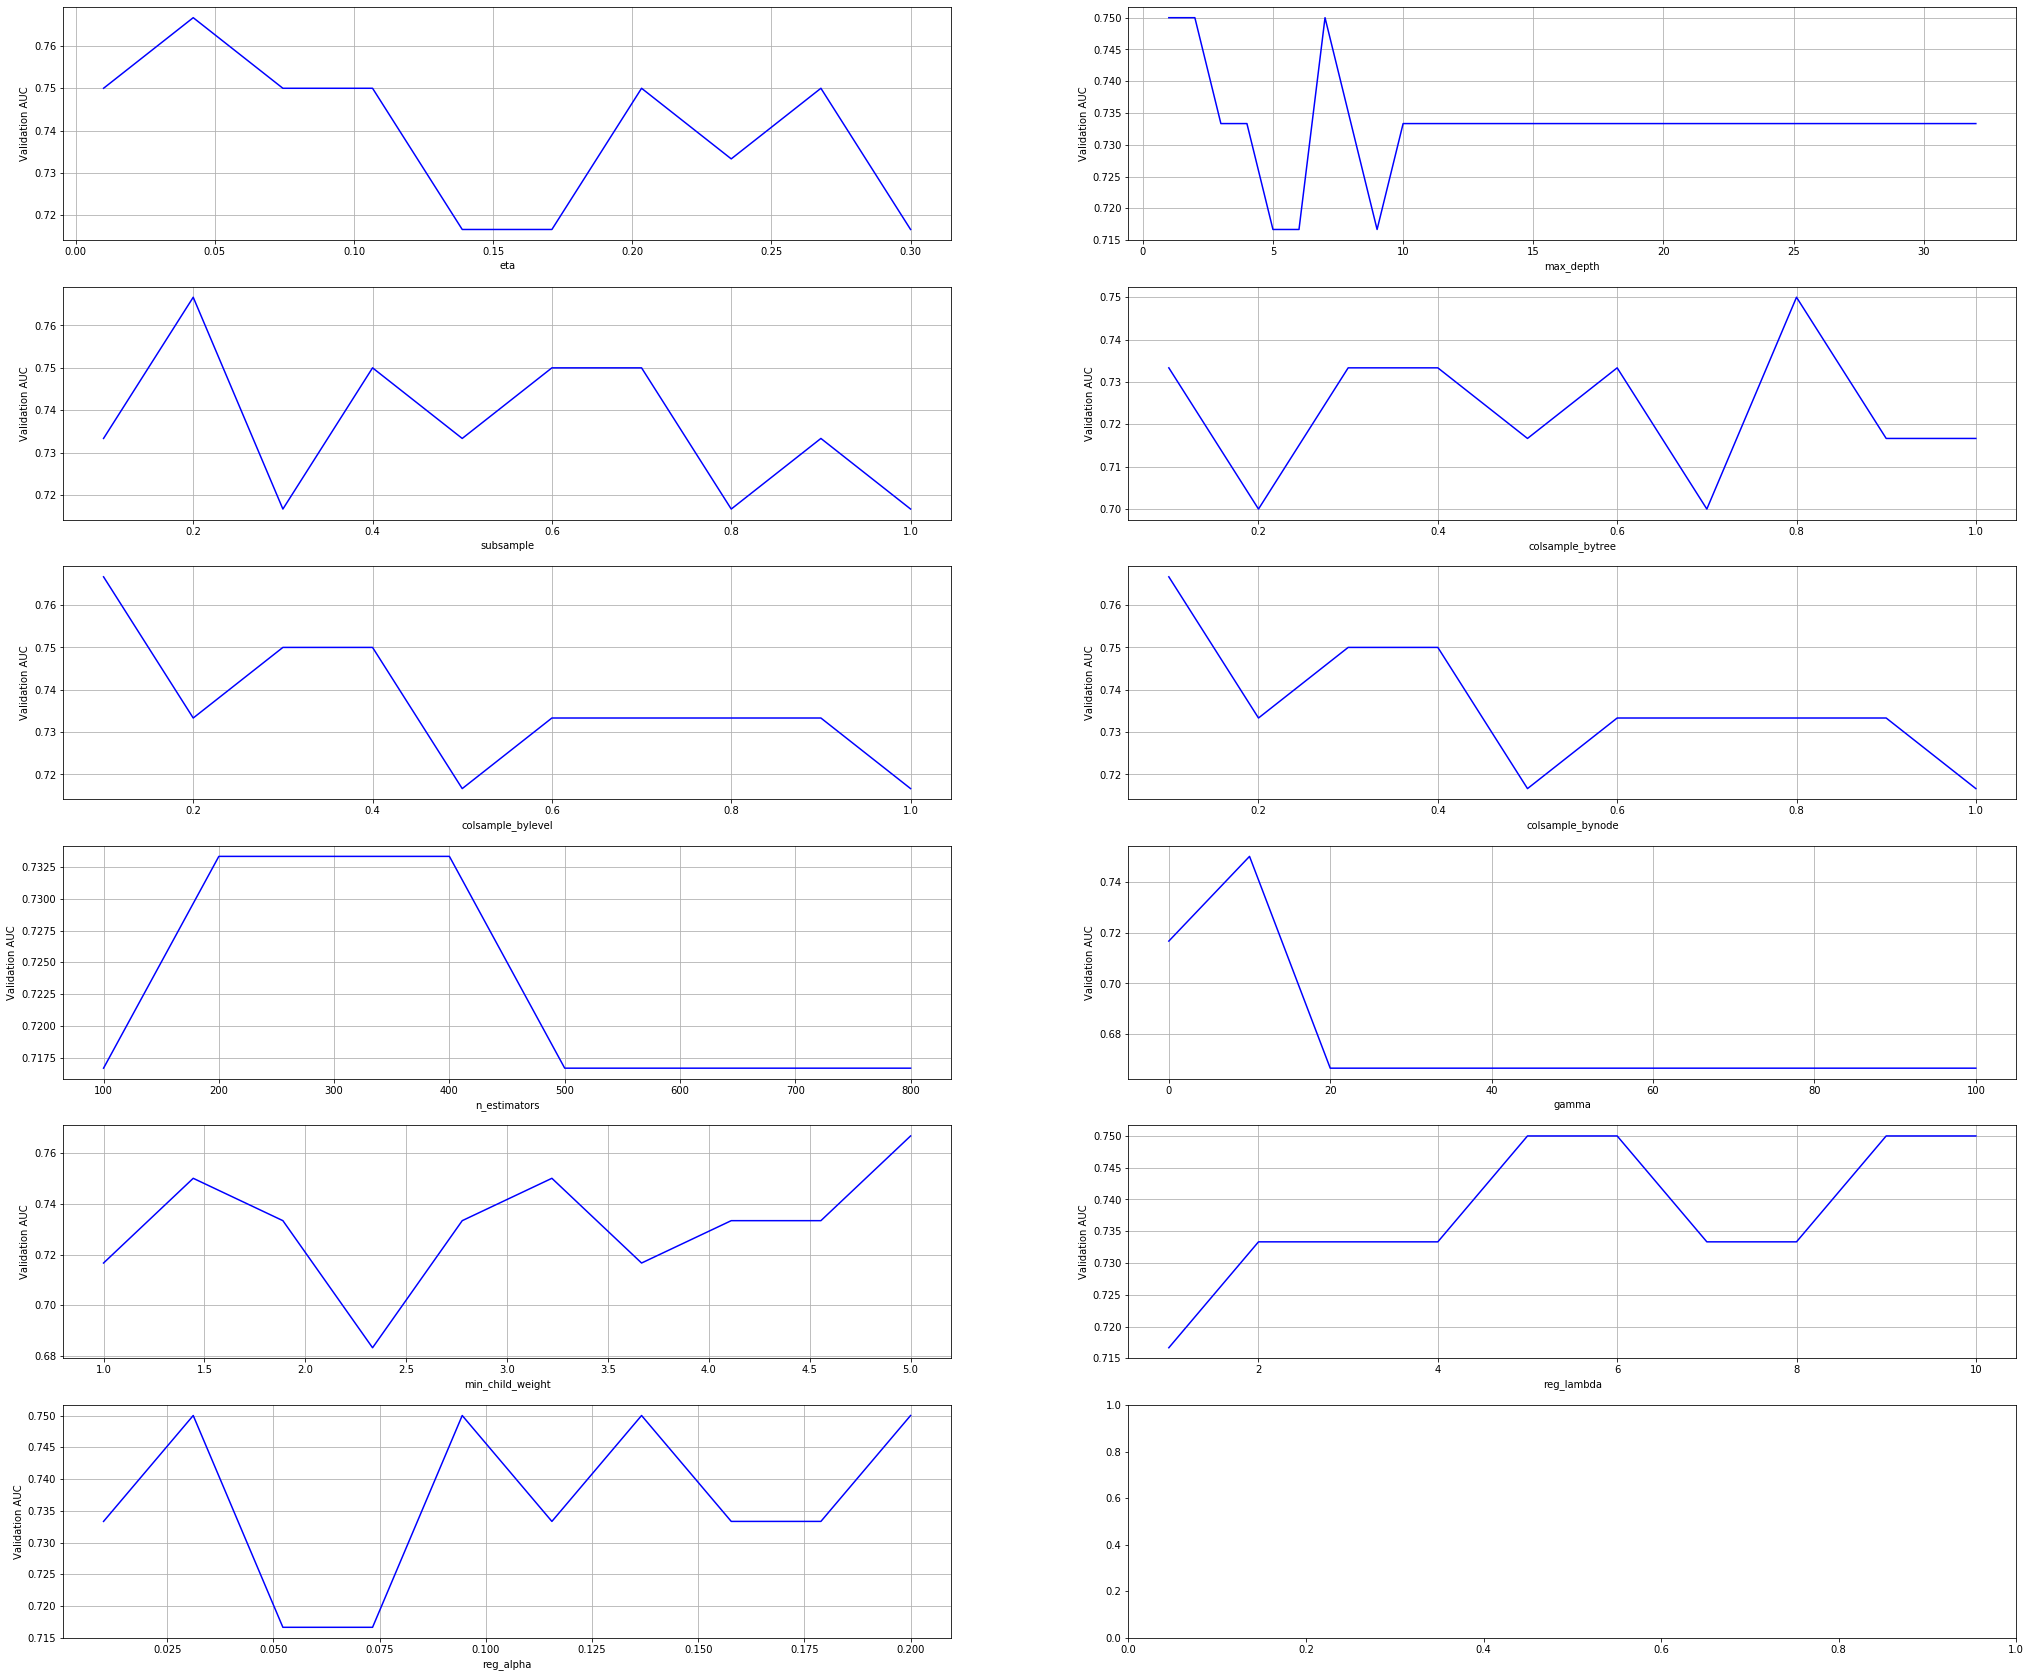

In [186]:
visualise_fold(fold_acc)

In [187]:
def hyperopt(param_space, X_train, y_train, X_test, y_test,num_eval, classifier,use_scaling = False):  
    start = time()
    def objective_function(params):
        clf = classifier(**params, random_state=1)
        model = clf.fit(X_train,y_train)
        predictions = model.predict(X_test)
        score = accuracy_score(y_test, predictions)
        return {'loss': -score, 'status': STATUS_OK}
    trials = Trials()
    best_param = fmin(objective_function, param_space, algo=tpe.suggest, max_evals=num_eval, 
                      trials=trials, rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials] 
    best_param_values = best_param
    return trials, best_param_values

In [188]:
num_eval = 50

XGB_param_hyperopt = {
    'eta':hp.uniform('eta', 0.01, 0.05),
    'booster': hp.choice('booster', ['gbtree', 'gblinear','dart']), 
    'max_depth': scope.int(hp.quniform('max_depth', 1, 12, 1)),
    'subsample': hp.uniform('subsample', 0.2, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.9),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.2, 0.4),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.2, 0.4),
    'gamma': hp.uniform('gamma', 0, 10),
    'min_child_weight': hp.uniform('min_child_weight', 2, 4.6),
    'n_estimators': 400,
    'reg_lambda': hp.uniform('reg_lambda', 3, 10),
    'reg_alpha':hp.uniform('reg_alpha', 0.04, 0.25),
}
try:
    XGB_hyperopt = load_file('Tuning/XGB_hyperopt.pkl')
except:
    XGB_hyperopt = hyperopt(XGB_param_hyperopt, X_train = training_data_input_features, y_train = target, 
                            X_test = validation_input_features , y_test = validation_target, 
                            num_eval = num_eval, classifier = XGBClassifier)
    save_file('Tuning/XGB_hyperopt.pkl', XGB_hyperopt)

[18:26:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:26:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:26:33] WARNING: C:\Users\Administrator\w

In [189]:
xg_chosen = XGB_hyperopt[1]
xg_chosen

{'booster': 2,
 'colsample_bylevel': 0.20827965903357015,
 'colsample_bynode': 0.31994718652856385,
 'colsample_bytree': 0.7889696828850252,
 'eta': 0.045674276885414006,
 'gamma': 0.8829622652984388,
 'max_depth': 10.0,
 'min_child_weight': 4.52186176082397,
 'reg_alpha': 0.15004237968443618,
 'reg_lambda': 4.49459079525944,
 'subsample': 0.20472900393345525}

In [190]:
xgboost_model = XGBClassifier(booster=['gbtree', 'gblinear','dart'][xg_chosen['booster']], max_depth=int(xg_chosen['max_depth']),
                                  subsample = xg_chosen['subsample'], colsample_bytree=xg_chosen['colsample_bytree'],
                                  colsample_bynode = xg_chosen['colsample_bynode'], 
                                  colsample_bylevel = xg_chosen['colsample_bylevel'],
                                  n_estimators = 400, reg_alpha = xg_chosen['reg_alpha'], reg_lambda = xg_chosen['reg_lambda'],
                                  gamma = xg_chosen['gamma'], min_child_weight = xg_chosen['min_child_weight'],
                                  random_state=1)

In [191]:
xgboost_model.fit(training_data_input_features, target)

XGBClassifier(base_score=0.5, booster='dart',
              colsample_bylevel=0.20827965903357015,
              colsample_bynode=0.31994718652856385,
              colsample_bytree=0.7889696828850252, gamma=0.8829622652984388,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=4.52186176082397, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=0,
              num_parallel_tree=1, random_state=1,
              reg_alpha=0.15004237968443618, reg_lambda=4.49459079525944,
              scale_pos_weight=1, subsample=0.20472900393345525,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [192]:
predictions = xgboost_model.predict(validation_input_features)

[[32  8]
 [ 7 13]]


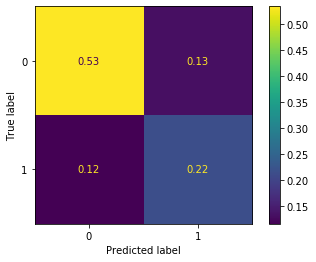

F1 score: 0.6341463414634146
Accuracy:  0.75
MCC:  0.4447495899966607
AUC: 0.7250000000000001


In [193]:
cm_normalized = confusion_matrix(validation_target, predictions, labels=[0,1],normalize='all')
ConfusionMatrixDisplay(cm_normalized, display_labels=[0,1]).plot()
print(confusion_matrix(validation_target, predictions, labels=[0,1]))
plt.show()
print("F1 score:",f1_score(validation_target,predictions))
print("Accuracy: ",accuracy_score(validation_target,predictions))
print("MCC: ", matthews_corrcoef(validation_target, predictions))
fpr, tpr, thresholds = roc_curve(validation_target, predictions)
print("AUC:",auc(fpr, tpr))

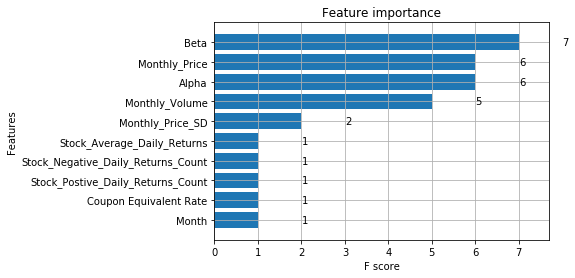

In [194]:
import xgboost as xgb
xgb.plot_importance(xgboost_model, max_num_features=10, height=0.8)

### Prepare Test Data (Feb2020 - Oct2020)

In [195]:
tickers = ["AAPL", "VZ","AMT", "T", "GOOG",
           "MRVL", "ATVI", "QCOM", "TMUS",
           "ERCA.BE", "VOD", "RNG", "ORA", "MAS",
           "CHL","QRVO", "BCE", "TEF",
           "SWKS", "LBTYA", "MU", "NXPI",
           "LPSN", "CHA", "IRDM", "MSI",
           "ILD.PA", "DISH", "NOK", "USM"]


daily_returns = get_daily_returns(tickers, start_date = "2020-02-03", end_date = "2020-10-31")
daily_returns["Month"] = daily_returns["Date"].apply(lambda x : x.month)
daily_returns

,Date,Ticker,Daily_Returns,Month
0,2020-02-04,AAPL,3.301372,2
1,2020-02-05,AAPL,0.815436,2
2,2020-02-06,AAPL,1.169683,2
3,2020-02-07,AAPL,-1.359262,2
4,2020-02-10,AAPL,0.474954,2
...,...,...,...,...
5665,2020-10-26,VZ,-0.258795,10
5666,2020-10-27,VZ,-0.743816,10
5667,2020-10-28,VZ,-1.864761,10
5668,2020-10-29,VZ,0.799142,10


#### Risk-Free rates

In [196]:
url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/TextView.aspx?data=billRatesYear&year=2020'

response = get(url)
html_soup = BeautifulSoup(response.text,'html.parser')
risk_free = pd.DataFrame(columns = ["Date","Coupon Equivalent Rate"])
data = html_soup.find_all('td', class_="text_view_data")
date = []
rate = []
n = len(data)
for i in range(0,n):
    if "/" in data[i].text:
        date.append(data[i].text[:-2] + "20"+ data[i].text[-2:] ) # Date
        rate.append(float(data[i+2].text)) #Coupon Equivalent Rate

risk_free = pd.DataFrame(columns = ["Date","Coupon Equivalent Rate"])
risk_free["Date"] = date
risk_free["Coupon Equivalent Rate"] = rate

risk_free["Date"] = risk_free["Date"].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').date())
risk_free["Date"] = pd.to_datetime(risk_free["Date"])
risk_free["Month"] = risk_free["Date"].apply(lambda x:x.month)

#Converting annual rate to monthly rate
risk_free["Coupon Equivalent Rate"] = risk_free["Coupon Equivalent Rate"].apply(lambda x : x/math.sqrt(12))
risk_free

,Date,Coupon Equivalent Rate,Month
0,2020-01-02,0.441673,1
1,2020-01-03,0.438786,1
2,2020-01-06,0.444560,1
3,2020-01-07,0.438786,1
4,2020-01-08,0.433013,1
...,...,...,...
212,2020-11-04,0.023094,11
213,2020-11-05,0.025981,11
214,2020-11-06,0.028868,11
215,2020-11-09,0.028868,11


## Merging the Datasets

In [197]:
merge_data = pd.merge(daily_returns, risk_free, how='left', on=['Date','Month'])
merge_data['RET_RF'] = merge_data['Daily_Returns'] - merge_data['Coupon Equivalent Rate']
merge_data

,Date,Ticker,Daily_Returns,Month,Coupon Equivalent Rate,RET_RF
0,2020-02-04,AAPL,3.301372,2,0.447446,2.853925
1,2020-02-05,AAPL,0.815436,2,0.447446,0.367990
2,2020-02-06,AAPL,1.169683,2,0.458993,0.710689
3,2020-02-07,AAPL,-1.359262,2,0.453220,-1.812482
4,2020-02-10,AAPL,0.474954,2,0.456107,0.018848
...,...,...,...,...,...,...
5665,2020-10-26,VZ,-0.258795,10,0.023094,-0.281889
5666,2020-10-27,VZ,-0.743816,10,0.023094,-0.766910
5667,2020-10-28,VZ,-1.864761,10,0.020207,-1.884968
5668,2020-10-29,VZ,0.799142,10,0.023094,0.776048


### Get Index Returns

In [198]:
index = ['VGT']
index_returns = get_daily_returns(index, start_date = "2020-02-03", end_date = "2020-10-31")
index_returns["Month"] = index_returns["Date"].apply(lambda x : x.month)
index_returns

,Date,Ticker,Daily_Returns,Month
0,2020-02-04,VGT,2.614912,2
1,2020-02-05,VGT,0.473322,2
2,2020-02-06,VGT,0.802714,2
3,2020-02-07,VGT,-0.934670,2
4,2020-02-10,VGT,1.245391,2
...,...,...,...,...
184,2020-10-26,VGT,-2.159449,10
185,2020-10-27,VGT,0.449119,10
186,2020-10-28,VGT,-3.992080,10
187,2020-10-29,VGT,1.417075,10


#### Merging Datasets

In [199]:
merge_data = merge_data.merge(index_returns, how='inner', left_on=['Month',"Date"], right_on=['Month',"Date"])
merge_data

,Date,Ticker_x,Daily_Returns_x,Month,Coupon Equivalent Rate,RET_RF,Ticker_y,Daily_Returns_y
0,2020-02-04,AAPL,3.301372,2,0.447446,2.853925,VGT,2.614912
1,2020-02-04,AMT,1.444009,2,0.447446,0.996562,VGT,2.614912
2,2020-02-04,ATVI,1.717917,2,0.447446,1.270470,VGT,2.614912
3,2020-02-04,BCE,0.660976,2,0.447446,0.213529,VGT,2.614912
4,2020-02-04,CHA,0.664294,2,0.447446,0.216848,VGT,2.614912
...,...,...,...,...,...,...,...,...
5665,2020-10-30,TEF,-1.190475,10,0.023094,-1.213569,VGT,-2.259910
5666,2020-10-30,TMUS,0.054787,10,0.023094,0.031693,VGT,-2.259910
5667,2020-10-30,USM,1.569588,10,0.023094,1.546494,VGT,-2.259910
5668,2020-10-30,VOD,-0.295203,10,0.023094,-0.318297,VGT,-2.259910


### Computing Index Returns on each Stock less the Risk - Free Rate

In [200]:
merge_data['Mkt_RF'] = merge_data['Daily_Returns_y'] - merge_data['Coupon Equivalent Rate']
merge_data

,Date,Ticker_x,Daily_Returns_x,Month,Coupon Equivalent Rate,RET_RF,Ticker_y,Daily_Returns_y,Mkt_RF
0,2020-02-04,AAPL,3.301372,2,0.447446,2.853925,VGT,2.614912,2.167466
1,2020-02-04,AMT,1.444009,2,0.447446,0.996562,VGT,2.614912,2.167466
2,2020-02-04,ATVI,1.717917,2,0.447446,1.270470,VGT,2.614912,2.167466
3,2020-02-04,BCE,0.660976,2,0.447446,0.213529,VGT,2.614912,2.167466
4,2020-02-04,CHA,0.664294,2,0.447446,0.216848,VGT,2.614912,2.167466
...,...,...,...,...,...,...,...,...,...
5665,2020-10-30,TEF,-1.190475,10,0.023094,-1.213569,VGT,-2.259910,-2.283004
5666,2020-10-30,TMUS,0.054787,10,0.023094,0.031693,VGT,-2.259910,-2.283004
5667,2020-10-30,USM,1.569588,10,0.023094,1.546494,VGT,-2.259910,-2.283004
5668,2020-10-30,VOD,-0.295203,10,0.023094,-0.318297,VGT,-2.259910,-2.283004


In [201]:
merge_data = merge_data[['Date','Month','Ticker_x','RET_RF','Mkt_RF']]
## Column renaming for convenience
merge_data["Ticker"] = merge_data['Ticker_x']
merge_data = merge_data[['Date','Month','Ticker','RET_RF','Mkt_RF']]

### Adding constant as the "alpha" Term

In [202]:
merge_data = sm.add_constant(merge_data)
merge_data = merge_data.dropna()
merge_data

,const,Date,Month,Ticker,RET_RF,Mkt_RF
0,1.0,2020-02-04,2,AAPL,2.853925,2.167466
1,1.0,2020-02-04,2,AMT,0.996562,2.167466
2,1.0,2020-02-04,2,ATVI,1.270470,2.167466
3,1.0,2020-02-04,2,BCE,0.213529,2.167466
4,1.0,2020-02-04,2,CHA,0.216848,2.167466
...,...,...,...,...,...,...
5665,1.0,2020-10-30,10,TEF,-1.213569,-2.283004
5666,1.0,2020-10-30,10,TMUS,0.031693,-2.283004
5667,1.0,2020-10-30,10,USM,1.546494,-2.283004
5668,1.0,2020-10-30,10,VOD,-0.318297,-2.283004


#### Run OLS to determine alpha

In [203]:
result = merge_data.groupby(["Ticker","Month"]).apply(ols_reg, features=['const','Mkt_RF'], output='RET_RF')
coef_alpha = [item.params[0] for item in result]
coef_beta = [item.params[1] for item in result]

computed = pd.DataFrame()
computed["Alpha"] = coef_alpha
computed["Beta"] = coef_beta
computed["Stock_Month"] = list(pd.DataFrame(merge_data.groupby(["Ticker","Month"]))[0])
computed["Ticker"] = computed["Stock_Month"].apply(lambda x : x[0])
computed["Month"] = computed["Stock_Month"].apply(lambda x : x[1])
computed

,Alpha,Beta,Stock_Month,Ticker,Month
0,0.009322,1.183715,"(AAPL, 2)",AAPL,2
1,0.145727,1.001740,"(AAPL, 3)",AAPL,3
2,0.101843,0.929079,"(AAPL, 4)",AAPL,4
3,0.157119,0.755679,"(AAPL, 5)",AAPL,5
4,0.325843,0.981488,"(AAPL, 6)",AAPL,6
...,...,...,...,...,...
265,-0.353757,0.500972,"(VZ, 6)",VZ,6
266,0.238024,-0.100434,"(VZ, 7)",VZ,7
267,0.162934,-0.080135,"(VZ, 8)",VZ,8
268,0.026858,0.135178,"(VZ, 9)",VZ,9


### Labelling for Positive Alpha

In [204]:
computed["Positive_alpha"] = np.where(computed['Alpha']>0, 1, 0)
computed

,Alpha,Beta,Stock_Month,Ticker,Month,Positive_alpha
0,0.009322,1.183715,"(AAPL, 2)",AAPL,2,1
1,0.145727,1.001740,"(AAPL, 3)",AAPL,3,1
2,0.101843,0.929079,"(AAPL, 4)",AAPL,4,1
3,0.157119,0.755679,"(AAPL, 5)",AAPL,5,1
4,0.325843,0.981488,"(AAPL, 6)",AAPL,6,1
...,...,...,...,...,...,...
265,-0.353757,0.500972,"(VZ, 6)",VZ,6,0
266,0.238024,-0.100434,"(VZ, 7)",VZ,7,1
267,0.162934,-0.080135,"(VZ, 8)",VZ,8,1
268,0.026858,0.135178,"(VZ, 9)",VZ,9,1


### Get the Average Volume of Stocks traded in the previous Period

In [205]:
volume = get_average_monthly_volume(tickers, start_date = "2020-02-03", end_date = "2020-10-31")
volume["Month"] = volume["Date"].apply(lambda x : x.month)
volume

,Date,Ticker,Monthly_Volume,Month
0,2020-02-03,AAPL,1.589395e+08,2
1,2020-02-03,AMT,2.105153e+06,2
2,2020-02-03,ATVI,6.627779e+06,2
3,2020-02-03,BCE,1.182132e+06,2
4,2020-02-03,CHA,7.440526e+04,2
...,...,...,...,...
265,2020-10-01,TEF,2.091268e+06,10
266,2020-10-01,TMUS,3.612173e+06,10
267,2020-10-01,USM,1.216182e+05,10
268,2020-10-01,VOD,4.307359e+06,10


### Get the Average Price of Stocks

In [206]:
average_price = get_average_monthly_prices(tickers, start_date = "2020-02-03", end_date = "2020-10-31")
average_price["Month"] = average_price["Date"].apply(lambda x : x.month)
average_price

,Date,Ticker,Monthly_Price,Month
0,2020-02-03,AAPL,76.667296,2
1,2020-02-03,AMT,244.262104,2
2,2020-02-03,ATVI,61.206842,2
3,2020-02-03,BCE,47.828948,2
4,2020-02-03,CHA,39.648947,2
...,...,...,...,...
265,2020-10-01,TEF,3.633636,10
266,2020-10-01,TMUS,113.983637,10
267,2020-10-01,USM,29.801364,10
268,2020-10-01,VOD,14.194091,10


### Get the SD of Price of Stocks traded

In [207]:
sd_price = get_sd_monthly_prices(tickers, start_date = "2020-02-03", end_date = "2020-10-31")
sd_price["Month"] = average_price["Date"].apply(lambda x : x.month)
sd_price

,Date,Ticker,Monthly_Price_SD,Month
0,2020-02-03,AAPL,4.273159,2
1,2020-02-03,AMT,8.751668,2
2,2020-02-03,ATVI,2.155943,2
3,2020-02-03,BCE,1.255764,2
4,2020-02-03,CHA,0.969340,2
...,...,...,...,...
265,2020-10-01,TEF,0.149493,10
266,2020-10-01,TMUS,3.084778,10
267,2020-10-01,USM,0.732980,10
268,2020-10-01,VOD,0.466299,10


### Compute the Risk-Free rate at the start of every month

In [208]:
## Get the Risk-free rate at the start of each month
risk_free_monthly = pd.DataFrame(risk_free["Coupon Equivalent Rate"].groupby(risk_free["Month"]))
risk_free_at_day1_month = pd.DataFrame(columns = ["Month", "Coupon Equivalent Rate"])
start_index = 0
end_index = 0
rates = []
for daily_rates in risk_free_monthly[1].tolist():
    rates.append(daily_rates[start_index])
    end_index = max(daily_rates.index)
    start_index = end_index +1

risk_free_at_day1_month["Coupon Equivalent Rate"] = rates
risk_free_at_day1_month["Month"] = risk_free_monthly[0]
risk_free_at_day1_month["Coupon Equivalent Rate"] = risk_free_at_day1_month["Coupon Equivalent Rate"]
risk_free_at_day1_month

,Month,Coupon Equivalent Rate
0,1,0.441673
1,2,0.450333
2,3,0.409919
3,4,0.008660
4,5,0.028868
5,6,0.034641
6,7,0.034641
7,8,0.025981
8,9,0.025981
9,10,0.025981


### Compute the average daily returns of any specific stock for each month

In [209]:
monthly_returns = pd.DataFrame(daily_returns.groupby(["Ticker","Month"])["Daily_Returns"].mean()).reset_index()
monthly_returns["Stock_Average_Daily_Returns"] = monthly_returns["Daily_Returns"]
monthly_returns = monthly_returns[["Ticker","Month","Stock_Average_Daily_Returns"]]

monthly_returns

,Ticker,Month,Stock_Average_Daily_Returns
0,AAPL,2,-0.629568
1,AAPL,3,-0.126148
2,AAPL,4,0.733876
3,AAPL,5,0.458161
4,AAPL,6,0.645928
...,...,...,...
265,VZ,6,-0.172007
266,VZ,7,0.244294
267,VZ,8,0.147657
268,VZ,9,0.020744


### Compute the number of positive and negative daily returns for any specific stock for each month

In [210]:
pos_neg_stock_returns= pd.DataFrame(daily_returns.groupby(["Ticker","Month"]).Daily_Returns.apply(lambda x: pd.Series([(x < 0).sum(), (x >= 0).sum()])).unstack())
pos_neg_stock_returns = pos_neg_stock_returns.reset_index()
pos_neg_stock_returns["Stock_Negative_Daily_Returns_Count"] = pos_neg_stock_returns[0]
pos_neg_stock_returns["Stock_Postive_Daily_Returns_Count"] = pos_neg_stock_returns[1]
pos_neg_stock_returns = pos_neg_stock_returns[["Stock_Negative_Daily_Returns_Count","Stock_Postive_Daily_Returns_Count",
                                              "Ticker","Month"]]
pos_neg_stock_returns

,Stock_Negative_Daily_Returns_Count,Stock_Postive_Daily_Returns_Count,Ticker,Month
0,10,8,AAPL,2
1,14,8,AAPL,3
2,9,12,AAPL,4
3,8,12,AAPL,5
4,6,16,AAPL,6
...,...,...,...,...
265,10,12,VZ,6
266,10,12,VZ,7
267,10,11,VZ,8
268,10,11,VZ,9


### Compute the average daily returns for all months of the index

In [211]:
index_monthly_returns = pd.DataFrame(index_returns.groupby(["Month"])["Daily_Returns"].mean()).reset_index()
index_monthly_returns["Index_Average_Daily_Returns"] = index_monthly_returns["Daily_Returns"]
index_monthly_returns = index_monthly_returns[["Month","Index_Average_Daily_Returns"]]
index_monthly_returns

,Month,Index_Average_Daily_Returns
0,2,-0.469068
1,3,-0.271218
2,4,0.677886
3,5,0.389227
4,6,0.325414
5,7,0.272559
6,8,0.509336
7,9,-0.210568
8,10,-0.187480


### Compute the number of positive and negative daily returns for index for each month

In [212]:
pos_neg_index_returns= pd.DataFrame(index_returns.groupby(["Month"]).Daily_Returns.apply(lambda x: pd.Series([(x < 0).sum(), (x >= 0).sum()])).unstack())
pos_neg_index_returns = pos_neg_index_returns.reset_index()
pos_neg_index_returns["Index_Negative_Daily_Returns_Count"] = pos_neg_index_returns[0]
pos_neg_index_returns["Index_Postive_Daily_Returns_Count"] = pos_neg_index_returns[1]
pos_neg_index_returns = pos_neg_index_returns[["Index_Negative_Daily_Returns_Count","Index_Postive_Daily_Returns_Count"
                                              ,"Month"]]
pos_neg_index_returns

,Index_Negative_Daily_Returns_Count,Index_Postive_Daily_Returns_Count,Month
0,9,9,2
1,12,10,3
2,9,12,4
3,6,14,5
4,6,16,6
5,8,14,7
6,6,15,8
7,10,11,9
8,13,9,10


### Merging of all Data

#### Apply Lag

In [213]:
temp = computed[["Month", "Ticker","Positive_alpha"]]
temp["Month"] = temp["Month"].apply(lambda x: x-1)
## Renaming columns to avoid confusion
temp["Next_Period_Positive_Alpha"] = temp["Positive_alpha"]
temp = temp[["Month", "Ticker","Next_Period_Positive_Alpha"]]
temp

,Month,Ticker,Next_Period_Positive_Alpha
0,1,AAPL,1
1,2,AAPL,1
2,3,AAPL,1
3,4,AAPL,1
4,5,AAPL,1
...,...,...,...
265,5,VZ,0
266,6,VZ,1
267,7,VZ,1
268,8,VZ,1


In [214]:
test_data = computed.merge(temp, how='inner', left_on=["Month","Ticker"], right_on=["Month","Ticker"])


test_data = test_data.merge(volume, how='inner', left_on=["Ticker", "Month"], right_on=["Ticker","Month"])
test_data = test_data.merge(average_price, how='inner', left_on=["Ticker", "Month"], right_on=["Ticker","Month"])
test_data = test_data.merge(sd_price, how='inner', left_on=["Ticker", "Month"], right_on=["Ticker","Month"])

test_data = test_data.merge(risk_free_at_day1_month, how='inner', left_on=["Month"], right_on=["Month"])

test_data = test_data.merge(monthly_returns, how='inner', left_on=["Ticker", "Month"], right_on=["Ticker","Month"])
test_data = test_data.merge(index_monthly_returns, how='inner', left_on=["Month"], right_on=["Month"])

test_data = test_data.merge(pos_neg_stock_returns, how='inner', left_on=["Ticker", "Month"], right_on=["Ticker","Month"])
test_data = test_data.merge(pos_neg_index_returns, how='inner', left_on=["Month"], right_on=["Month"])

test_data


,Alpha,Beta,Stock_Month,Ticker,Month,Positive_alpha,Next_Period_Positive_Alpha,Date_x,Monthly_Volume,Date_y,Monthly_Price,Date,Monthly_Price_SD,Coupon Equivalent Rate,Stock_Average_Daily_Returns,Index_Average_Daily_Returns,Stock_Negative_Daily_Returns_Count,Stock_Postive_Daily_Returns_Count,Index_Negative_Daily_Returns_Count,Index_Postive_Daily_Returns_Count
0,0.009322,1.183715,"(AAPL, 2)",AAPL,2,1,1,2020-02-03,1.589395e+08,2020-02-03,76.667296,2020-02-03,4.273159,0.450333,-0.629568,-0.469068,10,8,9,9
1,-0.297748,0.342675,"(AMT, 2)",AMT,2,0,1,2020-02-03,2.105153e+06,2020-02-03,244.262104,2020-02-03,8.751668,0.450333,-0.159203,-0.469068,10,8,9,9
2,0.107246,0.601122,"(ATVI, 2)",ATVI,2,1,1,2020-02-03,6.627779e+06,2020-02-03,61.206842,2020-02-03,2.155943,0.450333,0.006889,-0.469068,10,8,9,9
3,-0.413612,0.375194,"(BCE, 2)",BCE,2,0,1,2020-02-03,1.182132e+06,2020-02-03,47.828948,2020-02-03,1.255764,0.450333,-0.305126,-0.469068,10,8,9,9
4,-0.079920,0.591723,"(CHA, 2)",CHA,2,0,0,2020-02-03,7.440526e+04,2020-02-03,39.648947,2020-02-03,0.969340,0.450333,-0.171588,-0.469068,6,12,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,-0.622089,0.182167,"(TEF, 9)",TEF,9,0,1,2020-09-01,2.009257e+06,2020-09-01,3.703810,2020-09-01,0.184295,0.025981,-0.639312,-0.210568,11,10,10,11
236,0.044081,0.636627,"(TMUS, 9)",TMUS,9,1,0,2020-09-01,4.643543e+06,2020-09-01,113.058095,2020-09-01,2.339682,0.025981,-0.080582,-0.210568,11,10,10,11
237,-0.946369,0.242486,"(USM, 9)",USM,9,0,1,2020-09-01,1.427762e+05,2020-09-01,32.739048,2020-09-01,2.468754,0.025981,-0.977853,-0.210568,17,4,10,11
238,-0.432682,0.162309,"(VOD, 9)",VOD,9,0,1,2020-09-01,4.340371e+06,2020-09-01,13.903810,2020-09-01,0.426280,0.025981,-0.445210,-0.210568,13,8,10,11


### Selecting the relevant columns

In [215]:
test_data = test_data[["Month","Ticker", "Alpha", "Beta", "Monthly_Volume", 
                         "Monthly_Price", "Monthly_Price_SD","Positive_alpha", "Coupon Equivalent Rate",
                        "Stock_Average_Daily_Returns","Index_Average_Daily_Returns",
                         "Stock_Negative_Daily_Returns_Count","Stock_Postive_Daily_Returns_Count",
                         "Index_Negative_Daily_Returns_Count", "Index_Postive_Daily_Returns_Count",
                         "Next_Period_Positive_Alpha"]]
test_data

,Month,Ticker,Alpha,Beta,Monthly_Volume,Monthly_Price,Monthly_Price_SD,Positive_alpha,Coupon Equivalent Rate,Stock_Average_Daily_Returns,Index_Average_Daily_Returns,Stock_Negative_Daily_Returns_Count,Stock_Postive_Daily_Returns_Count,Index_Negative_Daily_Returns_Count,Index_Postive_Daily_Returns_Count,Next_Period_Positive_Alpha
0,2,AAPL,0.009322,1.183715,1.589395e+08,76.667296,4.273159,1,0.450333,-0.629568,-0.469068,10,8,9,9,1
1,2,AMT,-0.297748,0.342675,2.105153e+06,244.262104,8.751668,0,0.450333,-0.159203,-0.469068,10,8,9,9,1
2,2,ATVI,0.107246,0.601122,6.627779e+06,61.206842,2.155943,1,0.450333,0.006889,-0.469068,10,8,9,9,1
3,2,BCE,-0.413612,0.375194,1.182132e+06,47.828948,1.255764,0,0.450333,-0.305126,-0.469068,10,8,9,9,1
4,2,CHA,-0.079920,0.591723,7.440526e+04,39.648947,0.969340,0,0.450333,-0.171588,-0.469068,6,12,9,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,9,TEF,-0.622089,0.182167,2.009257e+06,3.703810,0.184295,0,0.025981,-0.639312,-0.210568,11,10,10,11,1
236,9,TMUS,0.044081,0.636627,4.643543e+06,113.058095,2.339682,1,0.025981,-0.080582,-0.210568,11,10,10,11,0
237,9,USM,-0.946369,0.242486,1.427762e+05,32.739048,2.468754,0,0.025981,-0.977853,-0.210568,17,4,10,11,1
238,9,VOD,-0.432682,0.162309,4.340371e+06,13.903810,0.426280,0,0.025981,-0.445210,-0.210568,13,8,10,11,1


### Test Target Values

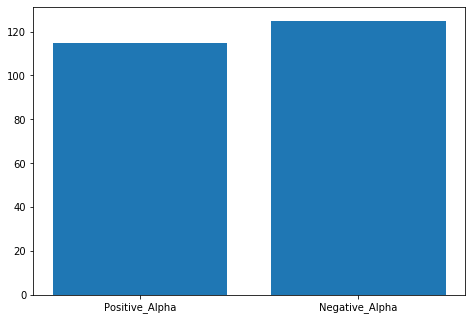

Number of Positive Alpha:  115
Number of Negative Alpha:  125


In [216]:
positive = len(test_data[test_data["Next_Period_Positive_Alpha"] == 1].index)
negative = len(test_data[test_data["Next_Period_Positive_Alpha"] == 0].index)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = ['Positive_Alpha', 'Negative_Alpha']
status = [positive,negative]
ax.bar(lab,status)
plt.show()
print("Number of Positive Alpha: ", positive)
print("Number of Negative Alpha: ", negative)

### Apply One-Hot Encoding for Tickers

In [217]:
#One-hot-encoding on Ticker: 
categorical = ['Ticker']
ticks = pd.get_dummies(test_data['Ticker']) 
test_data = test_data.drop(categorical, axis=1)
test_data = test_data.join([ticks])
test_data

,Month,Alpha,Beta,Monthly_Volume,Monthly_Price,Monthly_Price_SD,Positive_alpha,Coupon Equivalent Rate,Stock_Average_Daily_Returns,Index_Average_Daily_Returns,...,QCOM,QRVO,RNG,SWKS,T,TEF,TMUS,USM,VOD,VZ
0,2,0.009322,1.183715,1.589395e+08,76.667296,4.273159,1,0.450333,-0.629568,-0.469068,...,0,0,0,0,0,0,0,0,0,0
1,2,-0.297748,0.342675,2.105153e+06,244.262104,8.751668,0,0.450333,-0.159203,-0.469068,...,0,0,0,0,0,0,0,0,0,0
2,2,0.107246,0.601122,6.627779e+06,61.206842,2.155943,1,0.450333,0.006889,-0.469068,...,0,0,0,0,0,0,0,0,0,0
3,2,-0.413612,0.375194,1.182132e+06,47.828948,1.255764,0,0.450333,-0.305126,-0.469068,...,0,0,0,0,0,0,0,0,0,0
4,2,-0.079920,0.591723,7.440526e+04,39.648947,0.969340,0,0.450333,-0.171588,-0.469068,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,9,-0.622089,0.182167,2.009257e+06,3.703810,0.184295,0,0.025981,-0.639312,-0.210568,...,0,0,0,0,0,1,0,0,0,0
236,9,0.044081,0.636627,4.643543e+06,113.058095,2.339682,1,0.025981,-0.080582,-0.210568,...,0,0,0,0,0,0,1,0,0,0
237,9,-0.946369,0.242486,1.427762e+05,32.739048,2.468754,0,0.025981,-0.977853,-0.210568,...,0,0,0,0,0,0,0,1,0,0
238,9,-0.432682,0.162309,4.340371e+06,13.903810,0.426280,0,0.025981,-0.445210,-0.210568,...,0,0,0,0,0,0,0,0,1,0


In [218]:
input_features = test_data.loc[:, test_data.columns != 'Next_Period_Positive_Alpha']
target = test_data["Next_Period_Positive_Alpha"]

In [219]:
predictions = xgboost_model.predict(input_features)

[[84 41]
 [68 47]]


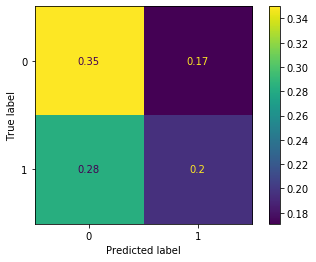

F1 score: 0.4630541871921182
Accuracy:  0.5458333333333333
MCC:  0.08365481295414615
AUC: 0.5403478260869565


In [220]:
cm_normalized = confusion_matrix(target, predictions, labels=[0,1],normalize='all')
ConfusionMatrixDisplay(cm_normalized, display_labels=[0,1]).plot()
print(confusion_matrix(target, predictions, labels=[0,1]))
plt.show()
print("F1 score:",f1_score(target,predictions))
print("Accuracy: ",accuracy_score(target,predictions))
print("MCC: ", matthews_corrcoef(target, predictions))

fpr, tpr, thresholds = roc_curve(target, predictions)
print("AUC:",auc(fpr, tpr))

# Qn5 (2)
Stocks with positive alpha predicted, (weight can be increased), while those stock with negative alpha predicted (extreme), weight can be decreased. (weight adjustments in Sept 2020)

In [221]:
test_data["Predictions"] = predictions
sept = test_data[test_data["Month"] == 9]
sept

,Month,Alpha,Beta,Monthly_Volume,Monthly_Price,Monthly_Price_SD,Positive_alpha,Coupon Equivalent Rate,Stock_Average_Daily_Returns,Index_Average_Daily_Returns,...,QRVO,RNG,SWKS,T,TEF,TMUS,USM,VOD,VZ,Predictions
210,9,-0.154384,1.386891,1.850365e+08,114.926960,6.974748,0,0.025981,-0.456417,-0.210568,...,0,0,0,0,0,0,0,0,0,1
211,9,-0.008153,0.500750,2.198757e+06,247.517142,7.918279,0,0.025981,-0.100693,-0.210568,...,0,0,0,0,0,0,0,0,0,0
212,9,0.029083,0.765233,6.748776e+06,80.342380,1.761686,1,0.025981,-0.125984,-0.210568,...,0,0,0,0,0,0,0,0,0,1
213,9,-0.055549,0.280323,1.331157e+06,42.276191,0.743716,0,0.025981,-0.095977,-0.210568,...,0,0,0,0,0,0,0,0,0,0
214,9,-0.384008,0.061124,5.744762e+04,31.737143,1.126730,0,0.025981,-0.372615,-0.210568,...,0,0,0,0,0,0,0,0,0,0
215,9,-0.377310,0.203896,1.119467e+06,33.705714,0.977761,0,0.025981,-0.399670,-0.210568,...,0,0,0,0,0,0,0,0,0,0
216,9,-0.816281,0.578000,2.539467e+06,31.640000,2.130854,0,0.025981,-0.927083,-0.210568,...,0,0,0,0,0,0,0,0,0,0
217,9,-0.474983,-0.322460,0.000000e+00,9.267500,0.200181,0,0.025981,-0.375053,-0.210568,...,0,0,0,0,0,0,0,0,0,0
218,9,-0.311029,0.818806,1.931810e+06,1518.553804,81.678826,0,0.025981,-0.478761,-0.210568,...,0,0,0,0,0,0,0,0,0,1
219,9,-0.470545,0.367751,8.241290e+04,167.080000,5.745534,0,0.025981,-0.529226,-0.210568,...,0,0,0,0,0,0,0,0,0,0


### Each stock weights will be increased or decreased by 5%. The decision to increase or decrease the stock depends on the prediction if the stock will have a positive alpha in the next period (Oct 2020), stocks with positive alpha willl have its weights increase by 5%,  stocks with a predicted negative alpha will have it's weight reduced by 5%.



In [222]:
positive_predicted = sept[sept["Predictions"] == 1]
positive_predicted

,Month,Alpha,Beta,Monthly_Volume,Monthly_Price,Monthly_Price_SD,Positive_alpha,Coupon Equivalent Rate,Stock_Average_Daily_Returns,Index_Average_Daily_Returns,...,QRVO,RNG,SWKS,T,TEF,TMUS,USM,VOD,VZ,Predictions
210,9,-0.154384,1.386891,1.850365e+08,114.926960,6.974748,0,0.025981,-0.456417,-0.210568,...,0,0,0,0,0,0,0,0,0,1
212,9,0.029083,0.765233,6.748776e+06,80.342380,1.761686,1,0.025981,-0.125984,-0.210568,...,0,0,0,0,0,0,0,0,0,1
218,9,-0.311029,0.818806,1.931810e+06,1518.553804,81.678826,0,0.025981,-0.478761,-0.210568,...,0,0,0,0,0,0,0,0,0,1
228,9,0.167498,0.789205,1.964624e+06,124.528571,3.379496,1,0.025981,0.006764,-0.210568,...,0,0,0,0,0,0,0,0,0,1
230,9,0.218166,1.023210,8.565857e+06,114.949524,3.489540,1,0.025981,0.002111,-0.210568,...,0,0,0,0,0,0,0,0,0,1
231,9,0.367370,1.278094,1.478276e+06,126.240952,4.910879,1,0.025981,0.091058,-0.210568,...,1,0,0,0,0,0,0,0,0,1
232,9,-0.039247,0.767119,1.192976e+06,268.207618,14.721311,0,0.025981,-0.194759,-0.210568,...,0,1,0,0,0,0,0,0,0,1
233,9,0.362308,1.310706,2.025629e+06,139.368570,5.122177,1,0.025981,0.078286,-0.210568,...,0,0,1,0,0,0,0,0,0,1
236,9,0.044081,0.636627,4.643543e+06,113.058095,2.339682,1,0.025981,-0.080582,-0.210568,...,0,0,0,0,0,1,0,0,0,1


In [223]:
negative_predicted = sept[sept["Predictions"] == 0]
negative_predicted

,Month,Alpha,Beta,Monthly_Volume,Monthly_Price,Monthly_Price_SD,Positive_alpha,Coupon Equivalent Rate,Stock_Average_Daily_Returns,Index_Average_Daily_Returns,...,QRVO,RNG,SWKS,T,TEF,TMUS,USM,VOD,VZ,Predictions
211,9,-0.008153,0.500750,2.198757e+06,247.517142,7.918279,0,0.025981,-0.100693,-0.210568,...,0,0,0,0,0,0,0,0,0,0
213,9,-0.055549,0.280323,1.331157e+06,42.276191,0.743716,0,0.025981,-0.095977,-0.210568,...,0,0,0,0,0,0,0,0,0,0
214,9,-0.384008,0.061124,5.744762e+04,31.737143,1.126730,0,0.025981,-0.372615,-0.210568,...,0,0,0,0,0,0,0,0,0,0
215,9,-0.377310,0.203896,1.119467e+06,33.705714,0.977761,0,0.025981,-0.399670,-0.210568,...,0,0,0,0,0,0,0,0,0,0
216,9,-0.816281,0.578000,2.539467e+06,31.640000,2.130854,0,0.025981,-0.927083,-0.210568,...,0,0,0,0,0,0,0,0,0,0
217,9,-0.474983,-0.322460,0.000000e+00,9.267500,0.200181,0,0.025981,-0.375053,-0.210568,...,0,0,0,0,0,0,0,0,0,0
219,9,-0.470545,0.367751,8.241290e+04,167.080000,5.745534,0,0.025981,-0.529226,-0.210568,...,0,0,0,0,0,0,0,0,0,0
220,9,-0.300693,0.527419,8.551286e+05,27.100476,1.742293,0,0.025981,-0.399538,-0.210568,...,0,0,0,0,0,0,0,0,0,0
221,9,-0.431128,0.356246,1.357357e+06,21.774762,0.866802,0,0.025981,-0.489505,-0.210568,...,0,0,0,0,0,0,0,0,0,0
222,9,-0.249923,1.471451,7.408952e+05,51.504286,3.801107,0,0.025981,-0.571947,-0.210568,...,0,0,0,0,0,0,0,0,0,0


In [224]:
weights_max_utility

OrderedDict([('AAPL', 0.0669385591243549),
             ('VZ', 0.015626530988775),
             ('AMT', 0.1062763879382531),
             ('T', 0.0),
             ('GOOG', 0.0507886973113026),
             ('MRVL', 0.0087570787417187),
             ('ATVI', 0.0258625660824788),
             ('QCOM', 0.0),
             ('TMUS', 0.0),
             ('ERCA.BE', 0.0594409907467118),
             ('VOD', 0.0),
             ('RNG', 0.2),
             ('ORA', 0.0),
             ('MAS', 0.0),
             ('CHL', 0.0),
             ('QRVO', 0.0),
             ('BCE', 0.0),
             ('TEF', 0.0),
             ('SWKS', 0.0),
             ('LBTYA', 0.0),
             ('MU', 0.0310135281665467),
             ('NXPI', 0.0),
             ('LPSN', 0.2),
             ('CHA', 0.0179241081447344),
             ('IRDM', 0.1016130209592798),
             ('MSI', 0.0796650028964607),
             ('ILD.PA', 0.0),
             ('DISH', 0.0),
             ('NOK', 0.0360935288993834),
             ('USM', 

In [225]:
positive_predicted.iloc[:,15:46]

,AAPL,AMT,ATVI,BCE,CHA,CHL,DISH,ERCA.BE,GOOG,ILD.PA,...,QRVO,RNG,SWKS,T,TEF,TMUS,USM,VOD,VZ,Predictions
210,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
212,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
218,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
228,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
231,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
232,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
233,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
236,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [226]:
postive_stocks = positive_predicted.iloc[:,15:45].columns
stocks = []
for stock in postive_stocks:
    if 1 in positive_predicted.iloc[:,15:45][stock].unique():
        stocks.append(stock)
stocks

['AAPL', 'ATVI', 'GOOG', 'NXPI', 'QCOM', 'QRVO', 'RNG', 'SWKS', 'TMUS']

In [227]:
import copy
new_weights = copy.deepcopy(weights_max_utility)
for stock in stocks:
    if(new_weights[stock] == 0):
        new_weights[stock] = 0.015
    else:
        new_weights[stock] = new_weights[stock] * 1.5
new_weights

OrderedDict([('AAPL', 0.10040783868653234),
             ('VZ', 0.015626530988775),
             ('AMT', 0.1062763879382531),
             ('T', 0.0),
             ('GOOG', 0.07618304596695391),
             ('MRVL', 0.0087570787417187),
             ('ATVI', 0.0387938491237182),
             ('QCOM', 0.015),
             ('TMUS', 0.015),
             ('ERCA.BE', 0.0594409907467118),
             ('VOD', 0.0),
             ('RNG', 0.30000000000000004),
             ('ORA', 0.0),
             ('MAS', 0.0),
             ('CHL', 0.0),
             ('QRVO', 0.015),
             ('BCE', 0.0),
             ('TEF', 0.0),
             ('SWKS', 0.015),
             ('LBTYA', 0.0),
             ('MU', 0.0310135281665467),
             ('NXPI', 0.015),
             ('LPSN', 0.2),
             ('CHA', 0.0179241081447344),
             ('IRDM', 0.1016130209592798),
             ('MSI', 0.0796650028964607),
             ('ILD.PA', 0.0),
             ('DISH', 0.0),
             ('NOK', 0.036093528899

In [228]:
negative_stocks = negative_predicted.iloc[:,15:45].columns
stocks = []
for stock in negative_stocks:
    if 1 in negative_predicted.iloc[:,15:45][stock].unique():
        stocks.append(stock)
stocks

['AMT',
 'BCE',
 'CHA',
 'CHL',
 'DISH',
 'ERCA.BE',
 'ILD.PA',
 'IRDM',
 'LBTYA',
 'LPSN',
 'MAS',
 'MRVL',
 'MSI',
 'MU',
 'NOK',
 'ORA',
 'T',
 'TEF',
 'USM',
 'VOD',
 'VZ']

In [229]:
for stock in stocks:
    new_weights[stock] = new_weights[stock] * 0.5
new_weights

OrderedDict([('AAPL', 0.10040783868653234),
             ('VZ', 0.0078132654943875),
             ('AMT', 0.05313819396912655),
             ('T', 0.0),
             ('GOOG', 0.07618304596695391),
             ('MRVL', 0.00437853937085935),
             ('ATVI', 0.0387938491237182),
             ('QCOM', 0.015),
             ('TMUS', 0.015),
             ('ERCA.BE', 0.0297204953733559),
             ('VOD', 0.0),
             ('RNG', 0.30000000000000004),
             ('ORA', 0.0),
             ('MAS', 0.0),
             ('CHL', 0.0),
             ('QRVO', 0.015),
             ('BCE', 0.0),
             ('TEF', 0.0),
             ('SWKS', 0.015),
             ('LBTYA', 0.0),
             ('MU', 0.01550676408327335),
             ('NXPI', 0.015),
             ('LPSN', 0.1),
             ('CHA', 0.0089620540723672),
             ('IRDM', 0.0508065104796399),
             ('MSI', 0.03983250144823035),
             ('ILD.PA', 0.0),
             ('DISH', 0.0),
             ('NOK', 0.0180467

In [230]:
total = 0
number_stocks = len(new_weights)
for i in range(0,number_stocks):
    total = total+ list(new_weights.items())[i][1]
print("Total weight adds up to {total}".format (total = total))

Total weight adds up to 0.9185898225181364


In [231]:
##Normalizing weights
factor = 1/sum(list(new_weights.values()))
list_keys = list(new_weights.keys())
for k in list_keys:
    new_weights[k] = new_weights[k] * factor

In [232]:
total = 0
number_stocks = len(new_weights)
for i in range(0,number_stocks):
    total = total+ list(new_weights.items())[i][1]
print("Total weight adds up to {total}".format (total = total))

Total weight adds up to 1.0000000000000002


In [233]:
optim_portfolio = get_data_for_multiple_stocks(tickers, start_date = "2020-10-01", end_date = "2020-10-31")
new_portfolio = (optim_portfolio * new_weights).sum(axis=1)
old_portfolio = (optim_portfolio * weights_max_utility).sum(axis=1)

Text(0.5, 1.0, 'Portfolio Returns')

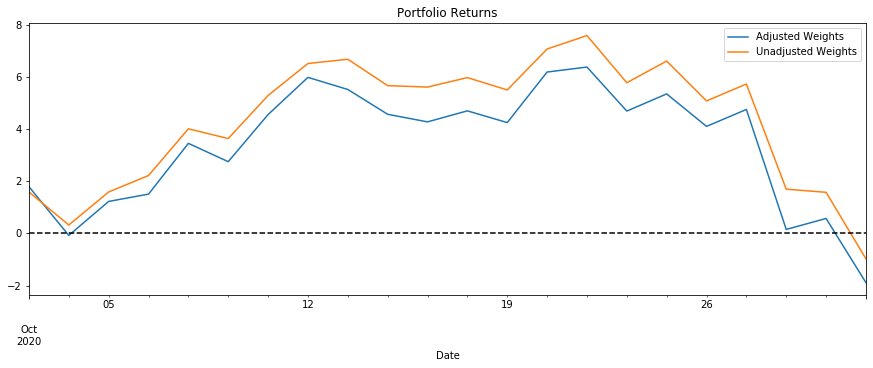

In [234]:
result = pd.concat([new_portfolio, old_portfolio], axis = 1)
result.columns = ["Adjusted Weights", "Unadjusted Weights"]
result.expanding().apply(lambda x: sum(x) * 100, raw=True).plot(figsize=(15,5))
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Portfolio Returns")

### Model Performance in Predicting Oct Alpha

[[ 9  3]
 [12  6]]


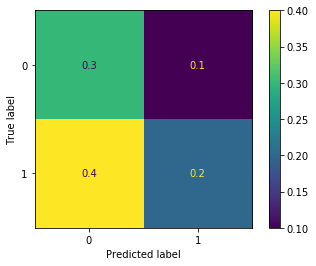

F1 score: 0.4444444444444444
Accuracy:  0.5
MCC:  0.0890870806374748
AUC: 0.5416666666666666


In [235]:
input_features = sept.loc[:, sept.columns !='Next_Period_Positive_Alpha']
input_features = input_features.loc[:, input_features.columns != 'Predictions']
target = sept["Next_Period_Positive_Alpha"]
predictions = xgboost_model.predict(input_features)
cm_normalized = confusion_matrix(target, predictions, labels=[0,1],normalize='all')
ConfusionMatrixDisplay(cm_normalized, display_labels=[0,1]).plot()
print(confusion_matrix(target, predictions, labels=[0,1]))
plt.show()
print("F1 score:",f1_score(target,predictions))
print("Accuracy: ",accuracy_score(target,predictions))
print("MCC: ", matthews_corrcoef(target, predictions))

fpr, tpr, thresholds = roc_curve(target, predictions)
print("AUC:",auc(fpr, tpr))

### Model Performance in Predicting Sept Alpha

[[18  2]
 [ 6  4]]


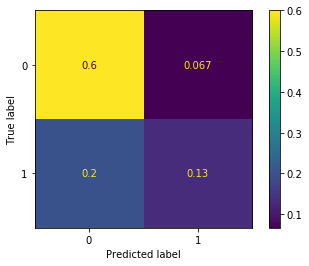

F1 score: 0.5
Accuracy:  0.7333333333333333
MCC:  0.35355339059327373
AUC: 0.65


In [236]:
aug= test_data[test_data["Month"] == 8]
input_features = aug.loc[:, aug.columns != 'Next_Period_Positive_Alpha']
input_features = input_features.loc[:, input_features.columns != 'Predictions']
target = aug["Next_Period_Positive_Alpha"]
predictions = xgboost_model.predict(input_features)
cm_normalized = confusion_matrix(target, predictions, labels=[0,1],normalize='all')
ConfusionMatrixDisplay(cm_normalized, display_labels=[0,1]).plot()
print(confusion_matrix(target, predictions, labels=[0,1]))
plt.show()
print("F1 score:",f1_score(target,predictions))
print("Accuracy: ",accuracy_score(target,predictions))
print("MCC: ", matthews_corrcoef(target, predictions))

fpr, tpr, thresholds = roc_curve(target, predictions)
print("AUC:",auc(fpr, tpr))